<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Leyenda de terminología:

- **Datos Crudos**: Son los datos originales, sin ningún tipo de procesamiento.
- **Datos Normalizados**: Son los datos que han pasado por un proceso de normalización, es decir, se han convertido a una escala común.
- **Datos No Controlables**: Son los datos que no se pueden controlar, como por ejemplo, las impresiones de un video.
- **Datos Controlables**: Son los datos que se pueden controlar, como por ejemplo, la duración de un video.
</div>

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Lo primero que vamos a realizar, es ingresar los datos en un dataframe, lo cuales fueron realizados a mano en notas.
</div>

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from kmodes.kprototypes import KPrototypes
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from scipy import stats

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
La cantidad de datos presentes cuenta con una diversidad bien amplia, por lo que optaremos por usar K-Prototypes, ya que este puede trabajar fácilmente con datos numéricos y categóricos, esto debido a que combina el uso de K-means (para datos numéricos) y K-Modes (para datos categóricos).

Dado que tenemos una diversa variedad de datos, vamos a tratar cada grupo de datos con una técnica de normalización diferente, usando la que más se acople al modelo. Partiendo de esa base, usaremos:

La normalización es necesaria debido a las diferentes escalas que tienen todos los valores númericos presentes, del mismo los categóricos que ni siquiera son números.

Lo primero será realizar las pruebas para definir que técnica de normalización se ajusta mejor a los datos.
</div>

In [5]:
df = pd.read_csv('videos.csv')

In [6]:
valores_numéricos = [
    'Longitud título', 'Vistas', 'Tiempo de reproducción (horas)', 'Suscriptores', 'Duración Promedio (Seg)',
    'Impresiones', 'Longitud descripción', 'Descripción sentimiento positivo', 'Duración (segundos)', 'Cantidad de emojis en el título',
    'Cantidad de emojis en las descripción', 'Cantidad de hashtags en el título', 'Cantidad de hashtags en la descripción','Mes de publicación'
]

In [7]:
# valores_numéricos = [
#     'Longitud título', 'Vistas', 'Suscriptores',
#     'Longitud descripción', 'Descripción sentimiento positivo', 'Duración (segundos)', 'Cantidad de emojis en el título',
#     'Cantidad de emojis en las descripción', 'Cantidad de hashtags en el título', 'Cantidad de hashtags en la descripción','Mes de publicación'
# ]

In [8]:
# valores_numéricos = [
#     'Longitud título', 'Vistas',
#     'Longitud descripción', 'Descripción sentimiento positivo', 'Duración (segundos)', 'Cantidad de emojis en el título',
#     'Cantidad de emojis en las descripción', 'Cantidad de hashtags en el título', 'Cantidad de hashtags en la descripción','Mes de publicación'
# ]

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Vamos a ver como se comportan los datos, entiéndase que distribución tienen.
</div>

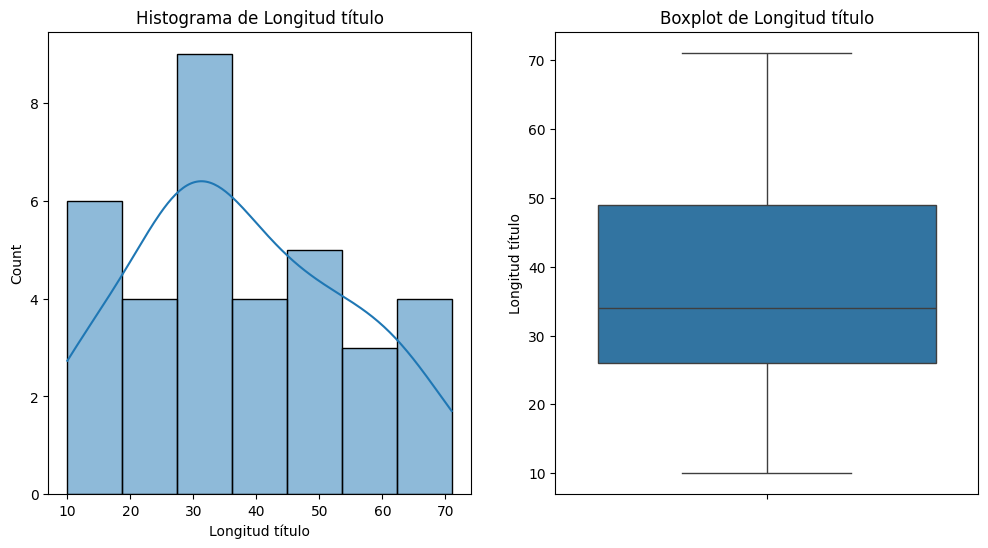

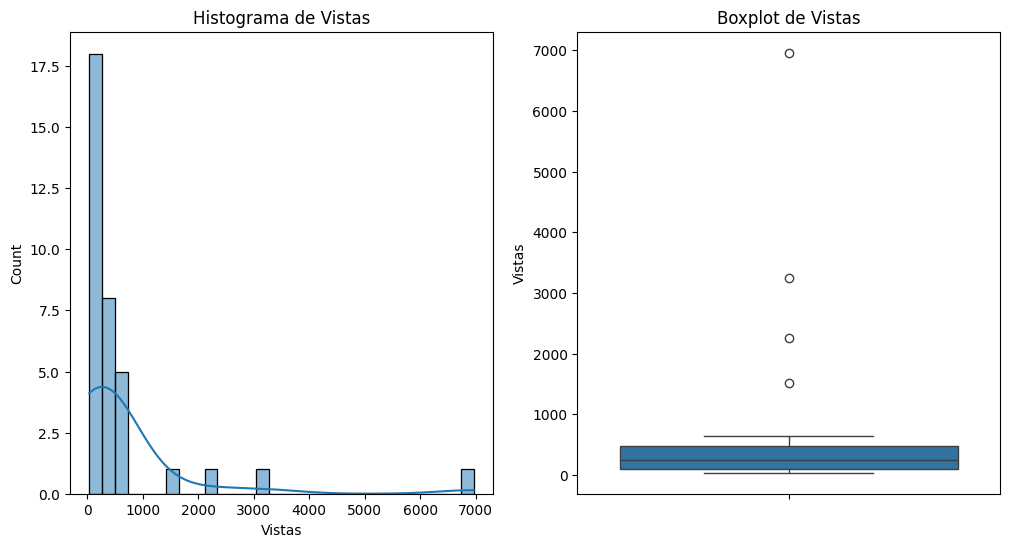

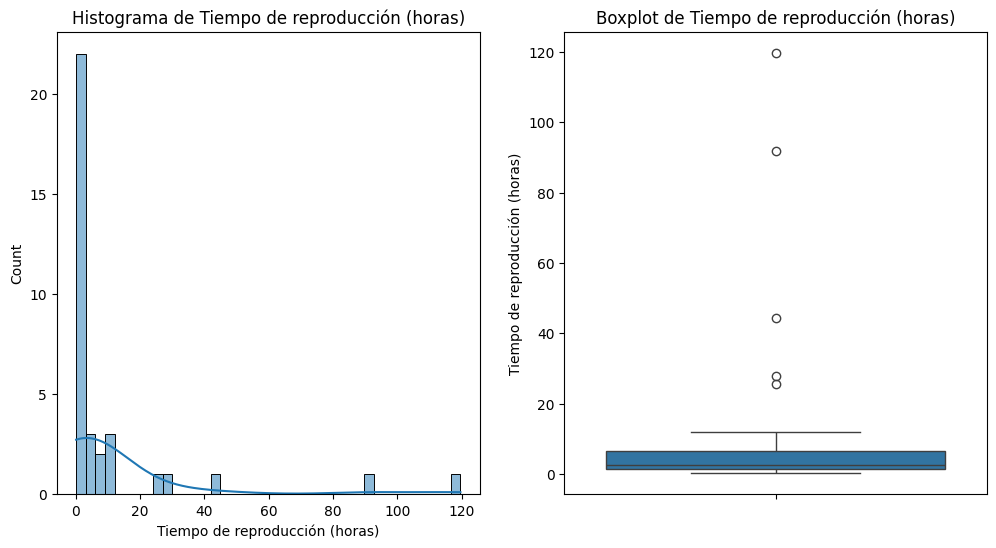

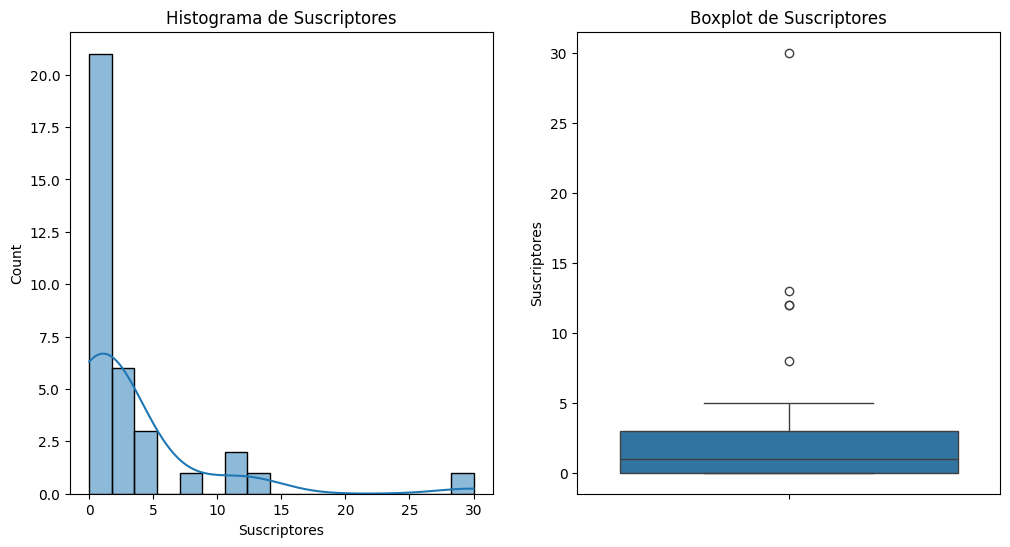

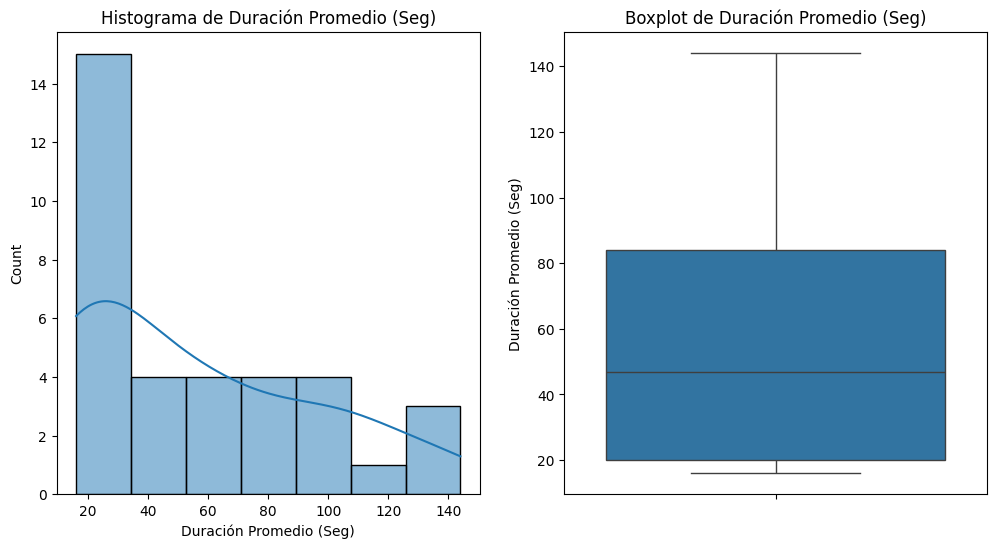

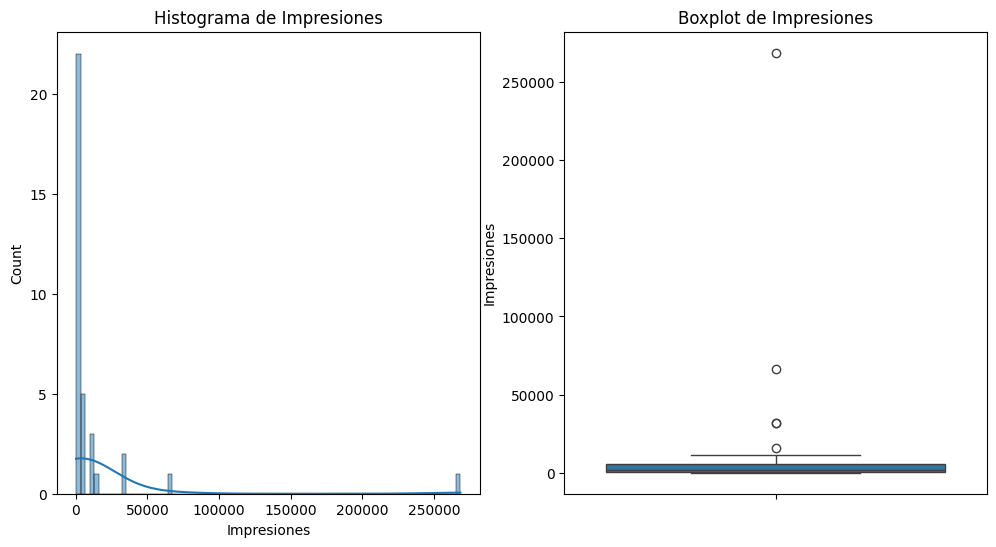

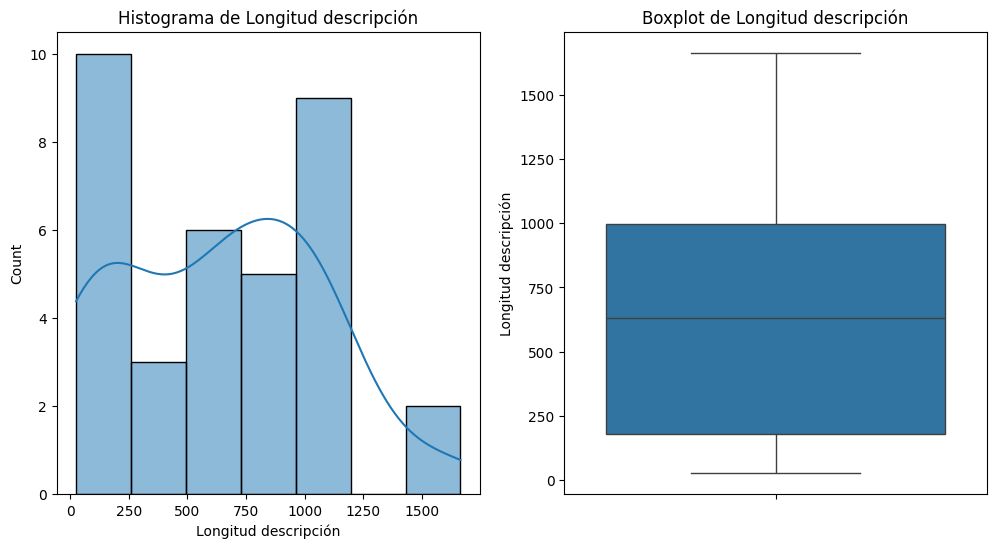

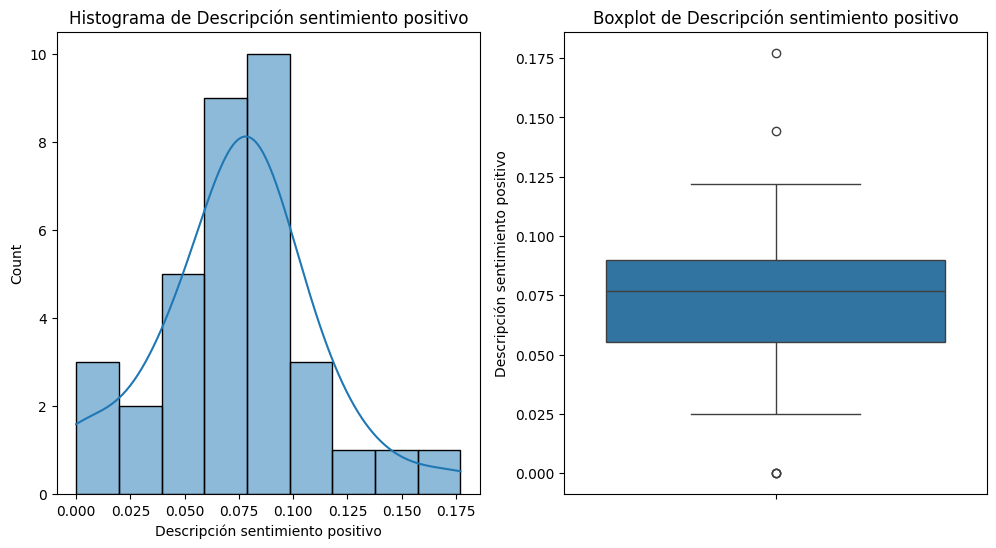

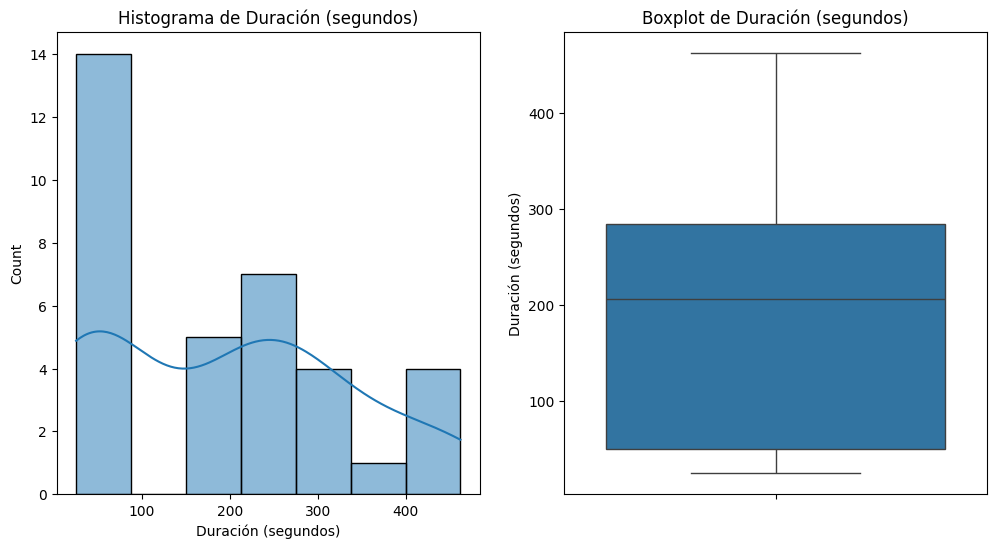

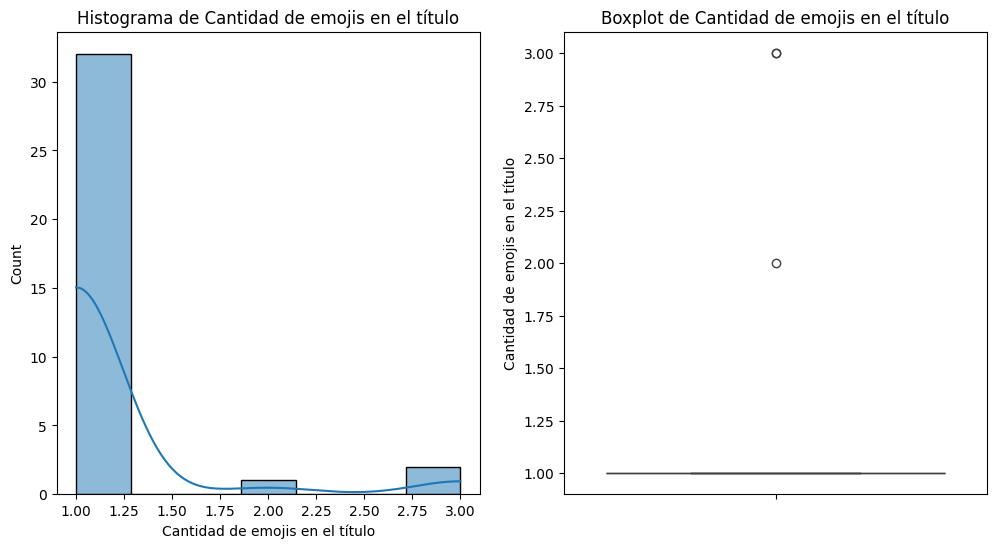

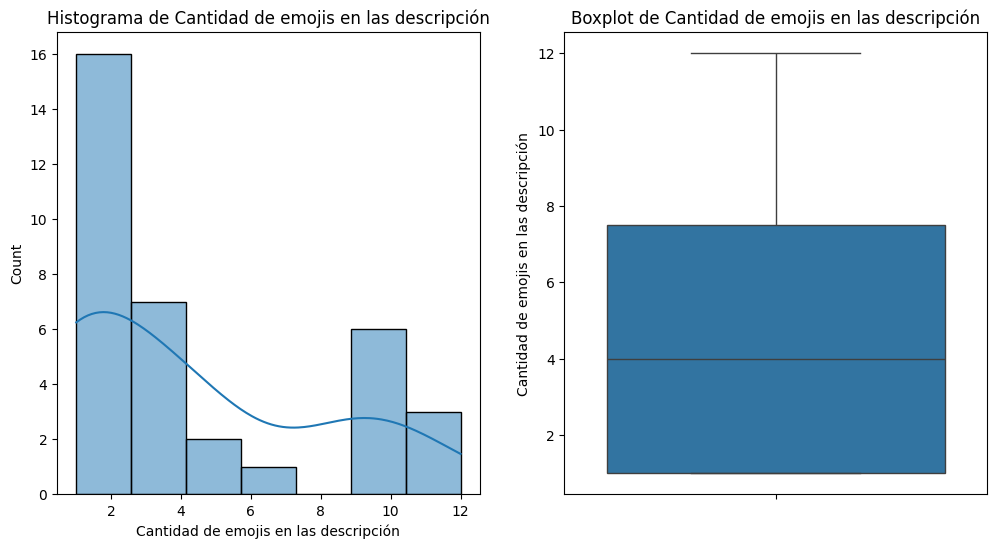

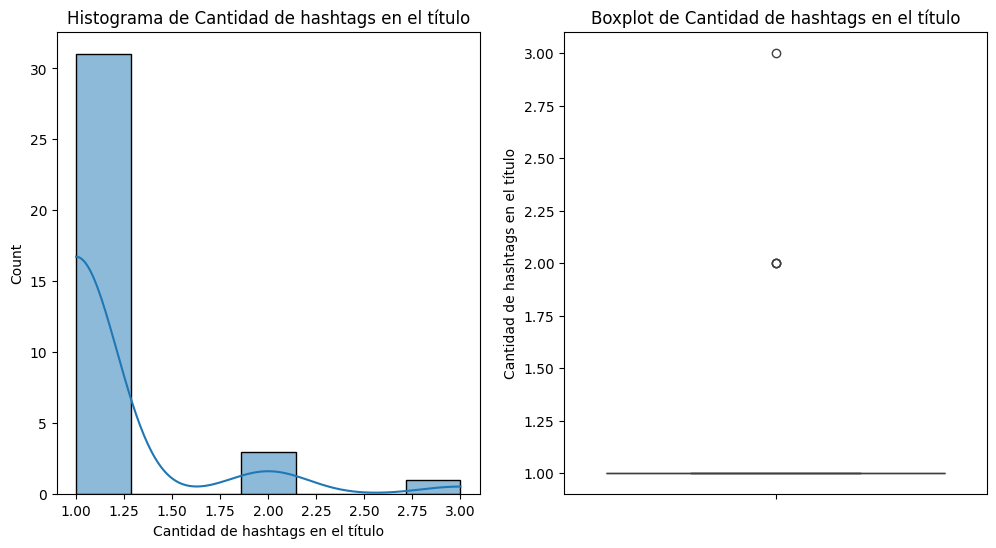

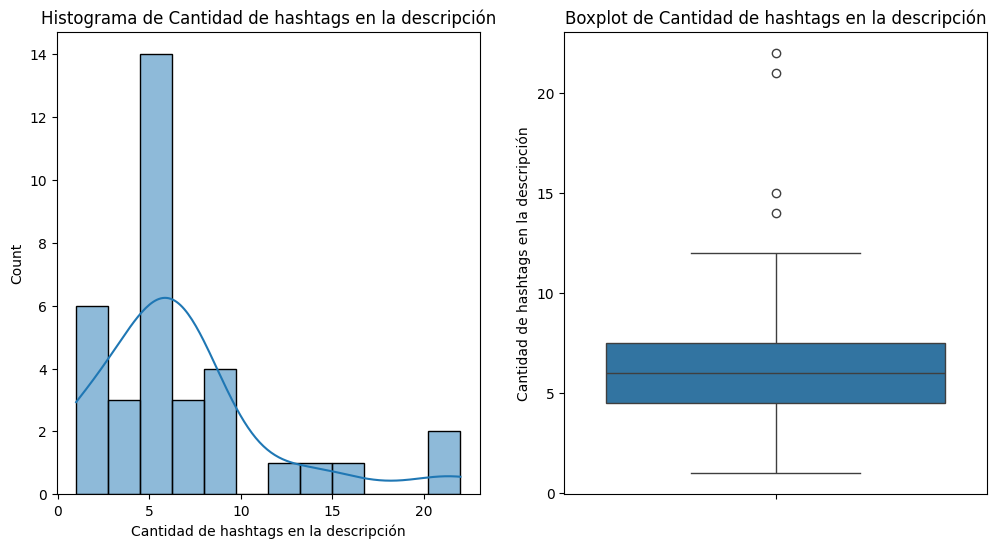

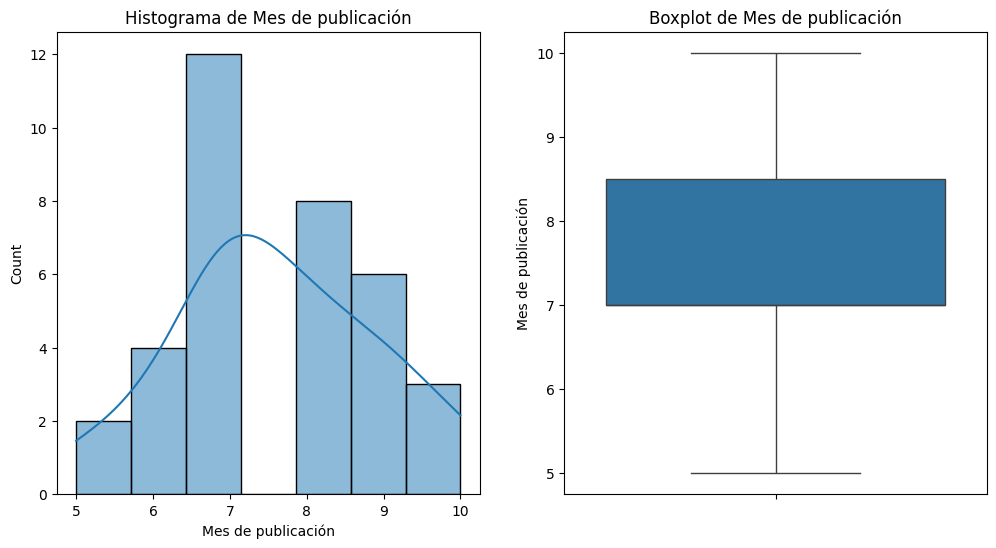

In [9]:
for col in valores_numéricos:
    plt.figure(figsize=(12, 6))

    # Histograma con KDE
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Histograma de {col}")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(df[col])
    plt.title(f"Boxplot de {col}")

    plt.show()

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Visualmente podemos ver que la mayoría de los datos no presentan una distribución normal. Pero lo vamos a comprobar numéricamente con la prueba de Shapiro, que nos permitirá saber si los datos provienen de una distribución normal ya que comprueba la hipótesis nula de que los datos provienen de una distribución normal.
</div>

In [10]:
df_distribuciones_normales = pd.DataFrame(columns=['Variable', 'p-value', 'Distribución'])

In [11]:
for col in valores_numéricos:
    stat, p_value = stats.shapiro(df[col])
    if p_value > 0.05:
        distribución = 'Normal'
    else:
        distribución = 'No normal'

    nueva_entrada = pd.DataFrame ({
        'Variable': [col],
        'p-value': [p_value],
        'Distribución': [distribución]
    })
    
    df_distribuciones_normales = pd.concat([df_distribuciones_normales, nueva_entrada])

/var/folders/v3/220y2lqj4dgfzblbczbhhjtw0000gn/T/ipykernel_27870/2436944343.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_distribuciones_normales = pd.concat([df_distribuciones_normales, nueva_entrada])


In [12]:
df_distribuciones_normales

,Variable,p-value,Distribución
0,Longitud título,2.946917e-01,Normal
0,Vistas,2.973317e-10,No normal
0,Tiempo de reproducción (horas),4.330422e-10,No normal
0,Suscriptores,5.778243e-09,No normal
0,Duración Promedio (Seg),4.892147e-04,No normal
0,Impresiones,1.161625e-11,No normal
0,Longitud descripción,5.622264e-02,Normal
0,Descripción sentimiento positivo,2.022087e-01,Normal
0,Duración (segundos),1.500028e-03,No normal
0,Cantidad de emojis en el título,1.289463e-11,No normal


<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Luego de aplicar la prueba de Shapiro, podemos ver que los datos casi en su totalidad no provienen de una distribución normal, por lo que no podemos aplicar técnicas de normalización que requieran que los datos provengan de una distribución normal en todos los valores.

Vamos a realizar pruebas con las técnicas de normalización para ver cual se ajusta mejor a los datos y que resultados obtenemos si mezclamos las técnicas.
</div>

In [13]:
df = pd.read_csv('videos.csv')

In [14]:
# Basados en df_distribuciones, asignaremos dinamicamente que técnica de normalización aplicar a cada columna
for col in valores_numéricos:
    if df_distribuciones_normales[df_distribuciones_normales['Variable'] == col]['Distribución'].values[0] == 'Normal':
        standerScaler = StandardScaler()
        df[col] = standerScaler.fit_transform(df[[col]])
    else:
        minMaxScaler = MinMaxScaler()
        df[col] = minMaxScaler.fit_transform(df[[col]])

In [15]:
# Prueba usando solamente StandardScaler
for col in valores_numéricos:
        standerScaler = StandardScaler()
        df[col] = standerScaler.fit_transform(df[[col]])

In [16]:
# Prueba usando solamente MinMaxScaler
for col in valores_numéricos:
        minMaxScaler = MinMaxScaler()
        df[col] = minMaxScaler.fit_transform(df[[col]])

In [17]:
# Probando usando RobustScaler
for col in valores_numéricos:
        robustScaler = RobustScaler()
        df[col] = robustScaler.fit_transform(df[[col]])

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Independiente mente de las técnica de normalización que usemos, vamos a ver que cantidad de clusters es la que mejor se ajusta a los datos con el método del codo, tanto con K-means como con K-Prototypes.
</div>

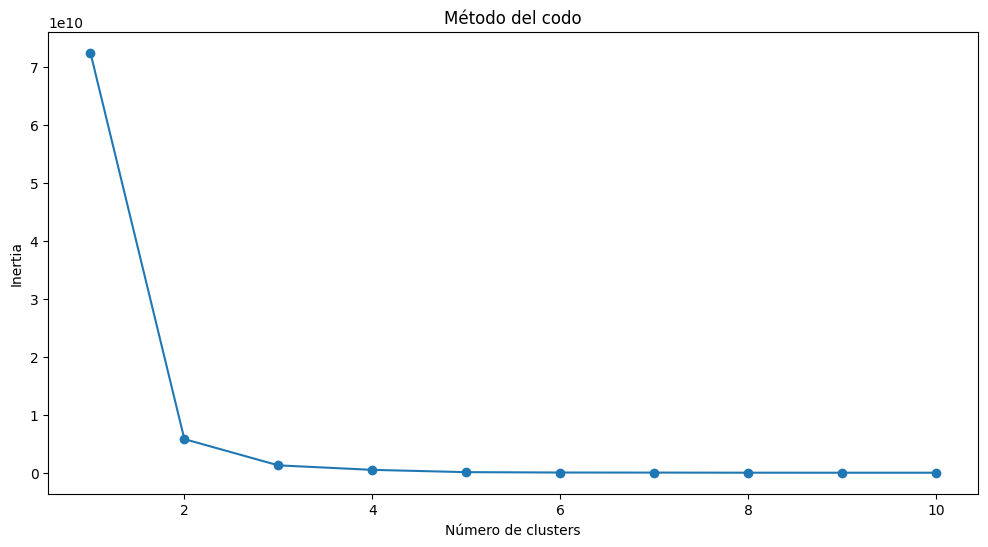

In [18]:
# Datos no normalizados usando K-means para hallar el número óptimo de clusters
df = pd.read_csv('videos.csv')

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[valores_numéricos])
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()


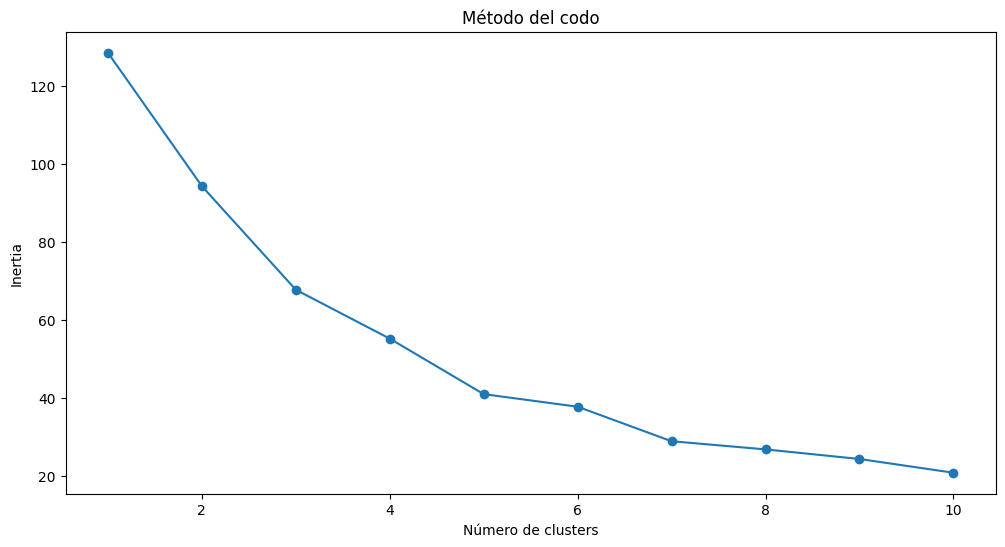

In [19]:
# Datos normalizados dinamicamente usando K-means
df = pd.read_csv('videos.csv')

# Basados en df_distribuciones, asignaremos dinamicamente que técnica de normalización aplicar a cada columna
for col in valores_numéricos:
    if df_distribuciones_normales[df_distribuciones_normales['Variable'] == col]['Distribución'].values[0] == 'Normal':
        standerScaler = StandardScaler()
        df[col] = standerScaler.fit_transform(df[[col]])
    else:
        minMaxScaler = MinMaxScaler()
        df[col] = minMaxScaler.fit_transform(df[[col]])

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[valores_numéricos])
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()

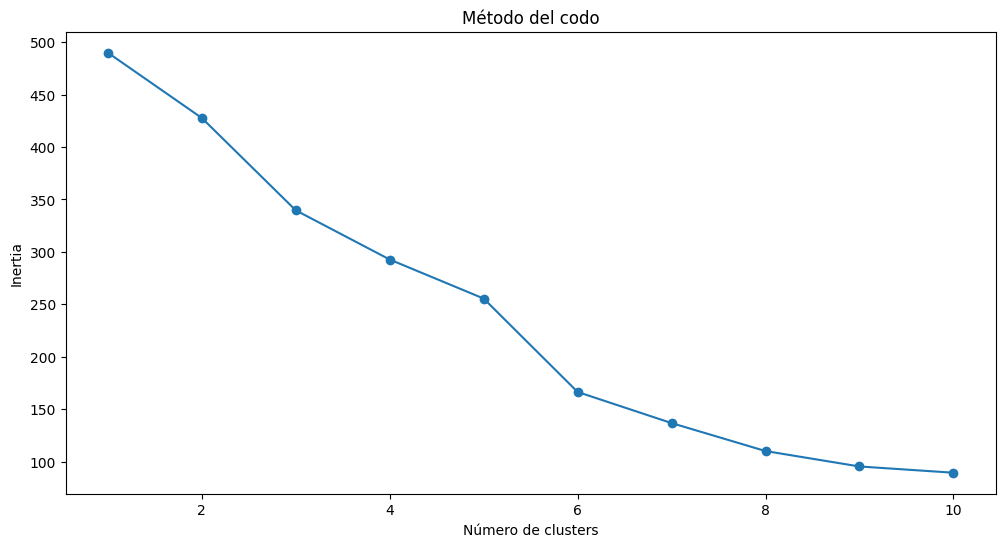

In [20]:
# Datos normalizados con Scaler usando K-means
df = pd.read_csv('videos.csv')

# Prueba usando solamente StandardScaler
for col in valores_numéricos:
        standerScaler = StandardScaler()
        df[col] = standerScaler.fit_transform(df[[col]])

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[valores_numéricos])
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()

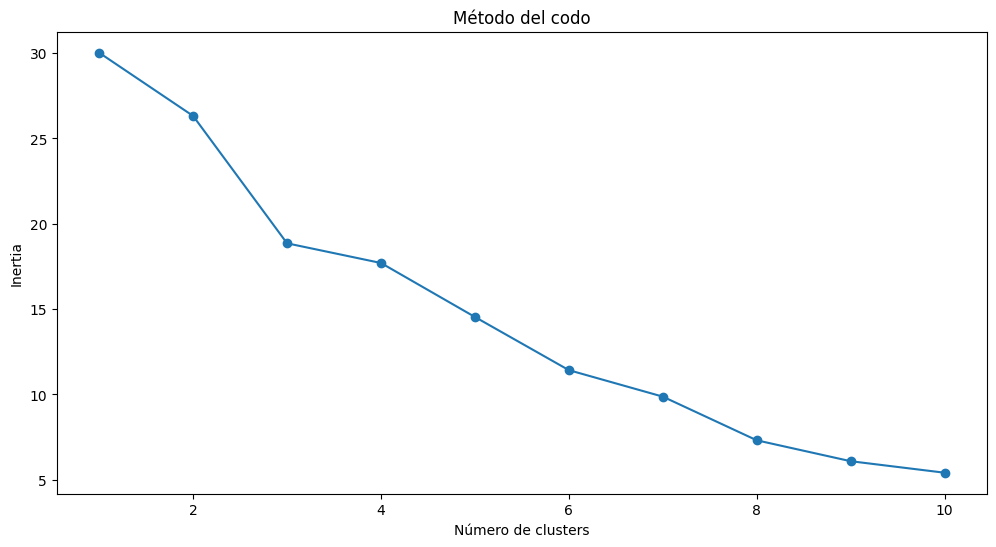

In [21]:
# Datos normalizados con MinMax usando K-means
df = pd.read_csv('videos.csv')

# Prueba usando solamente MinMaxScaler
for col in valores_numéricos:
        minMaxScaler = MinMaxScaler()
        df[col] = minMaxScaler.fit_transform(df[[col]])

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[valores_numéricos])
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()

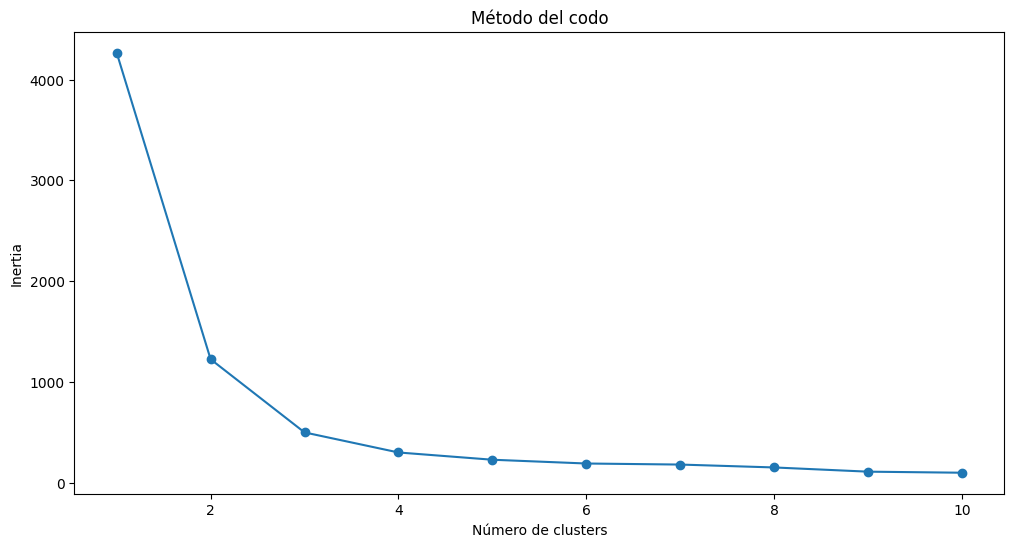

In [22]:
# Datos normalizados con RobustScaler usando K-means
df = pd.read_csv('videos.csv')

# Probando usando RobustScaler
for col in valores_numéricos:
        robustScaler = RobustScaler()
        df[col] = robustScaler.fit_transform(df[[col]])

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[valores_numéricos])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 99.18981707387712
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 99.18981707387712
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 99.18981707387712
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 99.18981707387712
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 99.18981707387712
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 99.18981707387712
Init: initializing centroids
Init: initializing clusters
Starting iterations..

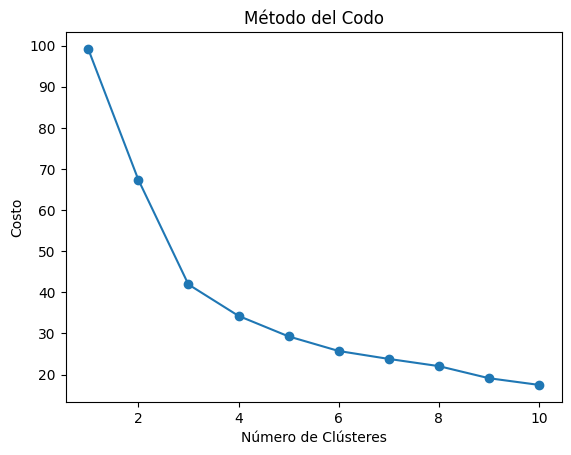

In [23]:
# Datos normalizados dinamicamente usando K-Prototype
df = pd.read_csv('videos.csv')

# Basados en df_distribuciones, asignaremos dinamicamente que técnica de normalización aplicar a cada columna
for col in valores_numéricos:
    if df_distribuciones_normales[df_distribuciones_normales['Variable'] == col]['Distribución'].values[0] == 'Normal':
        standerScaler = StandardScaler()
        df[col] = standerScaler.fit_transform(df[[col]])
    else:
        minMaxScaler = MinMaxScaler()
        df[col] = minMaxScaler.fit_transform(df[[col]])

max_clusters = 10
costs = []

for k in range(1, max_clusters + 1):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_init=10, verbose=1)
    kproto.fit(df[valores_numéricos], categorical=[0])
    costs.append(kproto.cost_)

plt.plot(range(1, max_clusters + 1), costs, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('Costo')
plt.show()

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 471.00000000000017
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 471.00000000000017
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 471.00000000000017
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 471.00000000000017
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 471.00000000000017
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 471.00000000000017
Init: initializing centroids
Init: initializing clusters
Starting iterat

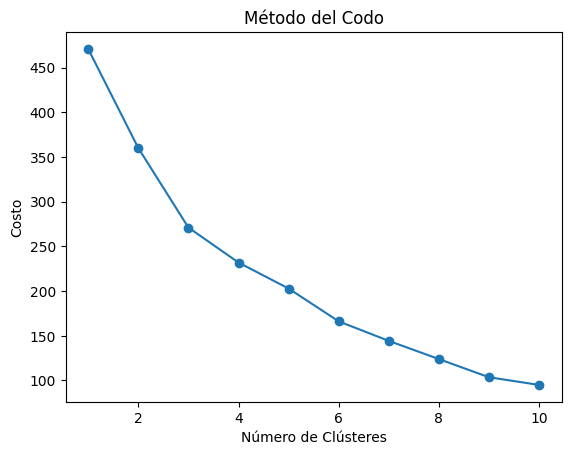

In [25]:
# Datos normalizados con Scaler usando K-Prototype
df = pd.read_csv('videos.csv')

# Prueba usando solamente StandardScaler
for col in valores_numéricos:
        standerScaler = StandardScaler()
        df[col] = standerScaler.fit_transform(df[[col]])

max_clusters = 10
costs = []

for k in range(1, max_clusters + 1):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_init=10, verbose=1)
    kproto.fit(df[valores_numéricos], categorical=[0])
    costs.append(kproto.cost_)

plt.plot(range(1, max_clusters + 1), costs, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('Costo')
plt.show()

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 31.24955023695766
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 31.24955023695766
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 31.24955023695766
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 31.24955023695766
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 31.24955023695766
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 31.24955023695766
Init: initializing centroids
Init: initializing clusters
Starting iterations..

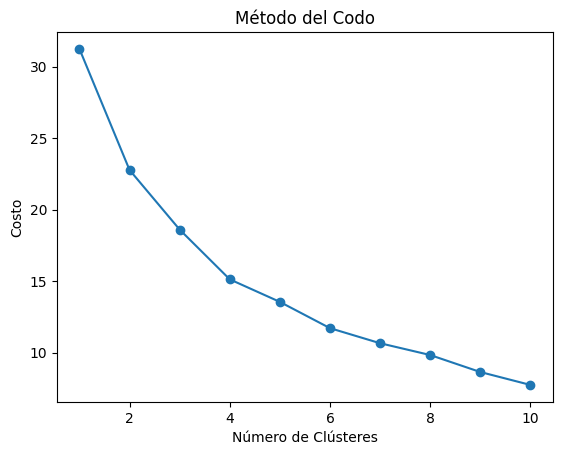

In [ ]:
# Datos normalizados con MinMax usando K-Prototype
df = pd.read_csv('videos.csv')

# Prueba usando solamente MinMaxScaler
for col in valores_numéricos:
        minMaxScaler = MinMaxScaler()
        df[col] = minMaxScaler.fit_transform(df[[col]])

max_clusters = 10
costs = []

for k in range(1, max_clusters + 1):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_init=10, verbose=1)
    kproto.fit(df[valores_numéricos], categorical=[0])
    costs.append(kproto.cost_)

# Graficar el costo en función del número de clústeres
plt.plot(range(1, max_clusters + 1), costs, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('Costo')
plt.show()

In [ ]:
# # Datos normalizados con RobustScaler usando K-Prototype
# df = pd.read_csv('videos.csv')

# # Probando usando RobustScaler
# for col in valores_numéricos:
#         robustScaler = RobustScaler()
#         df[col] = robustScaler.fit_transform(df[[col]])

# max_clusters = 10
# costs = []

# for k in range(1, max_clusters + 1):
#     kproto = KPrototypes(n_clusters=k, init='Cao', n_init=10, verbose=1)
#     kproto.fit(df[valores_numéricos], categorical=[0])
#     costs.append(kproto.cost_)

# # Graficar el costo en función del número de clústeres
# plt.plot(range(1, max_clusters + 1), costs, marker='o')
# plt.title('Método del Codo')
# plt.xlabel('Número de Clústeres')
# plt.ylabel('Costo')
# plt.show()

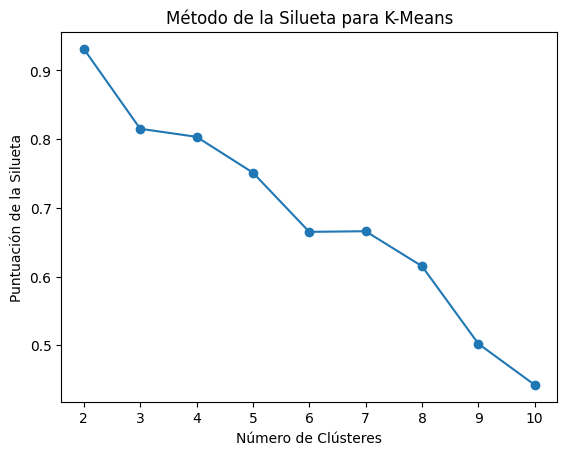

El número óptimo de clústeres es: 2 con una puntuación de la silueta de 0.931


In [ ]:
# Datos no normalizados usando K-means para hallar el número óptimo de clusters con Silhouette
df = pd.read_csv('videos.csv')

max_clusters = 10
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df[valores_numéricos])
    
    sil_score = silhouette_score(df[valores_numéricos], cluster_labels)
    silhouette_scores.append(sil_score)

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Método de la Silueta para K-Means')
plt.xlabel('Número de Clústeres')
plt.ylabel('Puntuación de la Silueta')
plt.show()

best_k = np.argmax(silhouette_scores) + 2
print(f"El número óptimo de clústeres es: {best_k} con una puntuación de la silueta de {silhouette_scores[best_k - 2]:.3f}")

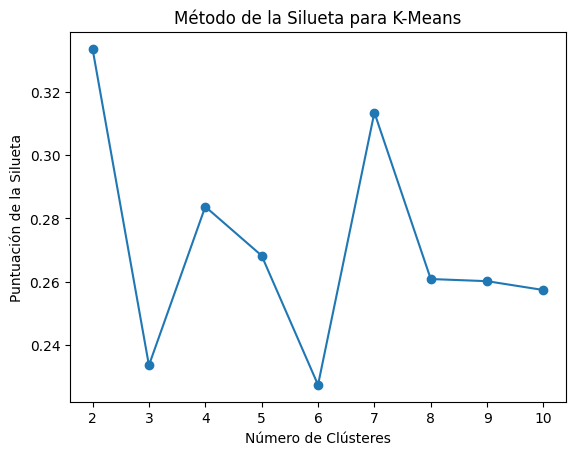

El número óptimo de clústeres es: 2 con una puntuación de la silueta de 0.334


In [ ]:
# Datos normalizados dinamicamente usando K-means para hallar el número óptimo de clusters con Silhouette
pd = pd.read_csv('videos.csv')

# Basados en df_distribuciones, asignaremos dinamicamente que técnica de normalización aplicar a cada columna
for col in valores_numéricos:
    if df_distribuciones_normales[df_distribuciones_normales['Variable'] == col]['Distribución'].values[0] == 'Normal':
        standerScaler = StandardScaler()
        df[col] = standerScaler.fit_transform(df[[col]])
    else:
        minMaxScaler = MinMaxScaler()
        df[col] = minMaxScaler.fit_transform(df[[col]])

max_clusters = 10
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df[valores_numéricos])
    
    sil_score = silhouette_score(df[valores_numéricos], cluster_labels)
    silhouette_scores.append(sil_score)

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Método de la Silueta para K-Means')
plt.xlabel('Número de Clústeres')
plt.ylabel('Puntuación de la Silueta')
plt.show()

best_k = np.argmax(silhouette_scores) + 2
print(f"El número óptimo de clústeres es: {best_k} con una puntuación de la silueta de {silhouette_scores[best_k - 2]:.3f}")

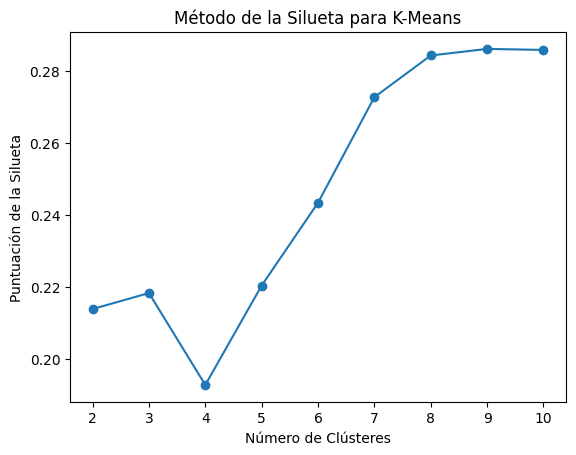

El número óptimo de clústeres es: 9 con una puntuación de la silueta de 0.286


In [ ]:
import pandas as pd

# Datos normalizados con Scaler usando K-means para hallar el número óptimo de clusters con Silhouette
df = pd.read_csv('videos.csv')

# Prueba usando solamente StandardScaler
for col in valores_numéricos:
        standerScaler = StandardScaler()
        df[col] = standerScaler.fit_transform(df[[col]])

max_clusters = 10
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df[valores_numéricos])
    
    sil_score = silhouette_score(df[valores_numéricos], cluster_labels)
    silhouette_scores.append(sil_score)

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Método de la Silueta para K-Means')
plt.xlabel('Número de Clústeres')
plt.ylabel('Puntuación de la Silueta')
plt.show()

best_k = np.argmax(silhouette_scores) + 2
print(f"El número óptimo de clústeres es: {best_k} con una puntuación de la silueta de {silhouette_scores[best_k - 2]:.3f}")

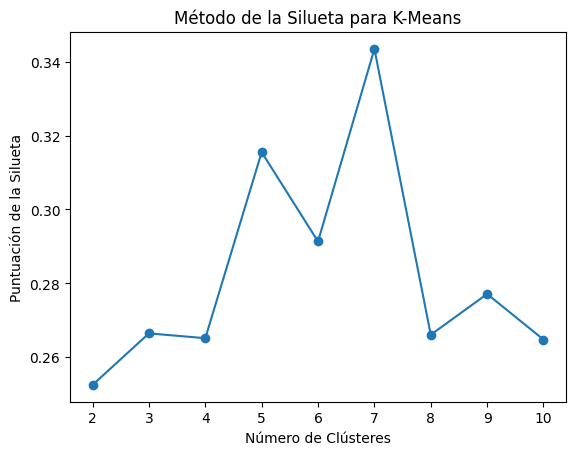

El número óptimo de clústeres es: 7 con una puntuación de la silueta de 0.343


In [ ]:
# Datos normalizados con MinMax usando K-means para hallar el número óptimo de clusters con Silhouette
df = pd.read_csv('videos.csv')

# Prueba usando solamente MinMaxScaler
for col in valores_numéricos:
        minMaxScaler = MinMaxScaler()
        df[col] = minMaxScaler.fit_transform(df[[col]])

max_clusters = 10
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df[valores_numéricos])
    
    sil_score = silhouette_score(df[valores_numéricos], cluster_labels)
    silhouette_scores.append(sil_score)

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Método de la Silueta para K-Means')
plt.xlabel('Número de Clústeres')
plt.ylabel('Puntuación de la Silueta')
plt.show()

best_k = np.argmax(silhouette_scores) + 2
print(f"El número óptimo de clústeres es: {best_k} con una puntuación de la silueta de {silhouette_scores[best_k - 2]:.3f}")

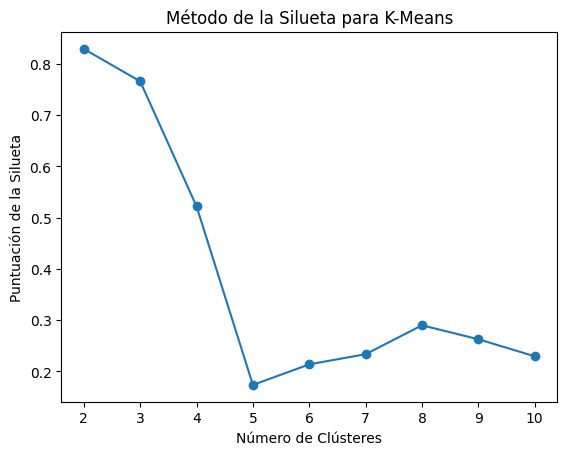

El número óptimo de clústeres es: 2 con una puntuación de la silueta de 0.829


In [ ]:
# Datos normalizados con RobustScaler usando K-means para hallar el número óptimo de clusters con Silhouette
df = pd.read_csv('videos.csv')

# Probando usando RobustScaler
for col in valores_numéricos:
        robustScaler = RobustScaler()
        df[col] = robustScaler.fit_transform(df[[col]])

max_clusters = 10
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df[valores_numéricos])
    
    sil_score = silhouette_score(df[valores_numéricos], cluster_labels)
    silhouette_scores.append(sil_score)

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Método de la Silueta para K-Means')
plt.xlabel('Número de Clústeres')
plt.ylabel('Puntuación de la Silueta')
plt.show()

best_k = np.argmax(silhouette_scores) + 2
print(f"El número óptimo de clústeres es: {best_k} con una puntuación de la silueta de {silhouette_scores[best_k - 2]:.3f}")

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 9, ncost: 70.35979899494437
Run: 1, iteration: 2/100, moves: 3, ncost: 68.72664785400738
Run: 1, iteration: 3/100, moves: 0, ncost: 68.72664785400738
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 5, ncost: 75.7327459585809
Run: 2, iteration: 2/100, moves: 0, ncost: 75.7327459585809
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 1, ncost: 67.5620062237235
Run: 3, iteration: 2/100, moves: 0, ncost: 67.5620062237235
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 4, ncost: 68.72664785400737
Run: 4, iteration: 2/100, moves: 0, ncost: 68.72664785400737
Init: initializing centroids
Init: initializing clusters
St

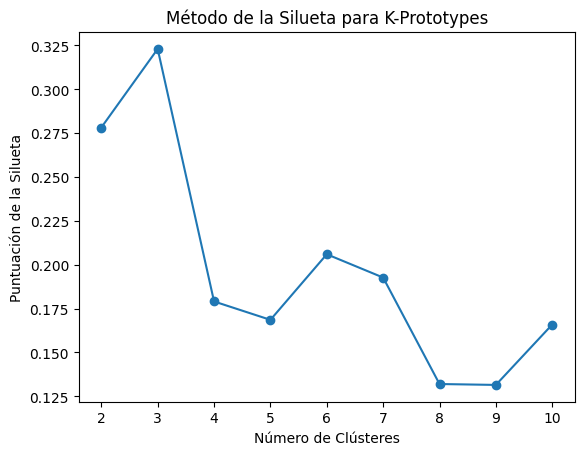

El número óptimo de clústeres es: 3 con una puntuación de la silueta de 0.323


In [ ]:
# Datos normalizado dinamicamente usando K-Prototype para hallar el número óptimo de clusters con Silhouette
pd = pd.read_csv('videos.csv')

# Basados en df_distribuciones, asignaremos dinamicamente que técnica de normalización aplicar a cada columna
for col in valores_numéricos:
    if df_distribuciones_normales[df_distribuciones_normales['Variable'] == col]['Distribución'].values[0] == 'Normal':
        standerScaler = StandardScaler()
        df[col] = standerScaler.fit_transform(df[[col]])
    else:
        minMaxScaler = MinMaxScaler()
        df[col] = minMaxScaler.fit_transform(df[[col]])

max_clusters = 10
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_init=10, verbose=2)
    cluster_labels = kproto.fit_predict(df[valores_numéricos], categorical=[0])

    sil_score = silhouette_score(df[valores_numéricos], cluster_labels)
    silhouette_scores.append(sil_score)

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Método de la Silueta para K-Prototypes')
plt.xlabel('Número de Clústeres')
plt.ylabel('Puntuación de la Silueta')
plt.show()

best_k = np.argmax(silhouette_scores) + 2
print(f"El número óptimo de clústeres es: {best_k} con una puntuación de la silueta de {silhouette_scores[best_k - 2]:.3f}")

https://stackoverflow.com/questions/62178888/can-someone-explain-to-me-how-minmaxscaler-works
https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
https://scipy.github.io/devdocs/reference/generated/scipy.stats.shapiro.html
https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.RobustScaler.html

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 7, ncost: 397.0813389647958
Run: 1, iteration: 2/100, moves: 4, ncost: 375.97348571933014
Run: 1, iteration: 3/100, moves: 1, ncost: 364.8308634494499
Run: 1, iteration: 4/100, moves: 0, ncost: 364.8308634494499
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 7, ncost: 364.8308634494499
Run: 2, iteration: 2/100, moves: 0, ncost: 364.8308634494499
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 5, ncost: 380.23980072542713
Run: 3, iteration: 2/100, moves: 0, ncost: 380.23980072542713
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...

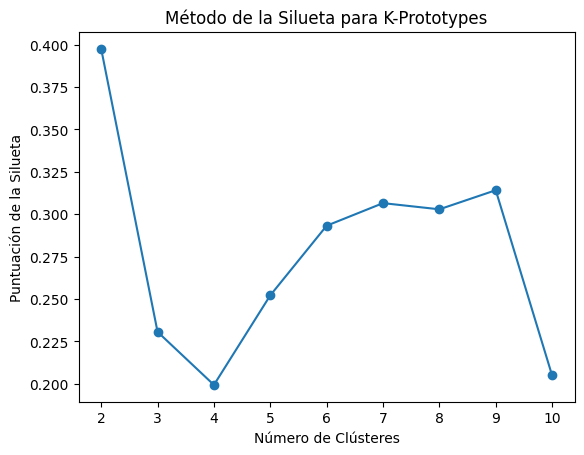

El número óptimo de clústeres es: 2 con una puntuación de la silueta de 0.398


In [ ]:
import pandas as pd

# Datos normalizado con Scaler usando K-Prototype para hallar el número óptimo de clusters con Silhouette
pd = pd.read_csv('videos.csv')

# Prueba usando solamente StandardScaler
for col in valores_numéricos:
        standerScaler = StandardScaler()
        df[col] = standerScaler.fit_transform(df[[col]])

max_clusters = 10
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_init=10, verbose=2)
    cluster_labels = kproto.fit_predict(df[valores_numéricos], categorical=[0])

    sil_score = silhouette_score(df[valores_numéricos], cluster_labels)
    silhouette_scores.append(sil_score)

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Método de la Silueta para K-Prototypes')
plt.xlabel('Número de Clústeres')
plt.ylabel('Puntuación de la Silueta')
plt.show()

best_k = np.argmax(silhouette_scores) + 2

print(f"El número óptimo de clústeres es: {best_k} con una puntuación de la silueta de {silhouette_scores[best_k - 2]:.3f}")

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 8, ncost: 23.03641281344438
Run: 1, iteration: 2/100, moves: 0, ncost: 23.03641281344438
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 2, ncost: 22.80672701507503
Run: 2, iteration: 2/100, moves: 0, ncost: 22.80672701507503
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 5, ncost: 26.687052599970865
Run: 3, iteration: 2/100, moves: 8, ncost: 23.036412813444382
Run: 3, iteration: 3/100, moves: 0, ncost: 23.036412813444382
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 6, ncost: 25.84070413711773
Run: 4, iteration: 2/100, moves: 7, ncost: 23.466701239786975
Run: 4, iteration: 3/100, moves: 1, ncost: 23.03641

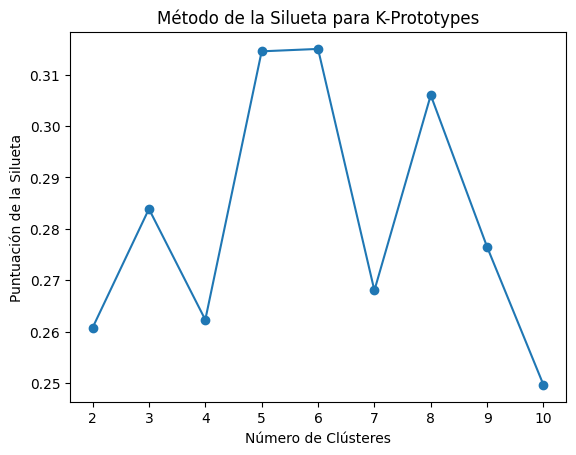

El número óptimo de clústeres es: 6 con una puntuación de la silueta de 0.315


In [ ]:
import pandas as pd

# Datos normalizados con MinMax usando K-Prototype para hallar el número óptimo de clusters con Silhouette
pd = pd.read_csv('videos.csv')

# Prueba usando solamente MinMaxScaler
for col in valores_numéricos:
        minMaxScaler = MinMaxScaler()
        df[col] = minMaxScaler.fit_transform(df[[col]])

max_clusters = 10
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_init=10, verbose=2)
    cluster_labels = kproto.fit_predict(df[valores_numéricos], categorical=[0])

    sil_score = silhouette_score(df[valores_numéricos], cluster_labels)
    silhouette_scores.append(sil_score)

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Método de la Silueta para K-Prototypes')
plt.xlabel('Número de Clústeres')
plt.ylabel('Puntuación de la Silueta')
plt.show()

best_k = np.argmax(silhouette_scores) + 2
print(f"El número óptimo de clústeres es: {best_k} con una puntuación de la silueta de {silhouette_scores[best_k - 2]:.3f}")

In [ ]:
# # Datos normalizados con RobustScaler usando K-Prototype para hallar el número óptimo de clusters con Silhouette
# pd = pd.read_csv('videos.csv')

# # Probando usando RobustScaler
# for col in valores_numéricos:
#         robustScaler = RobustScaler()
#         df[col] = robustScaler.fit_transform(df[[col]])

# max_clusters = 10
# silhouette_scores = []

# for k in range(2, max_clusters + 1):
#     kproto = KPrototypes(n_clusters=k, init='Cao', n_init=10, verbose=2)
#     cluster_labels = kproto.fit_predict(df[valores_numéricos], categorical=[0])

#     sil_score = silhouette_score(df[valores_numéricos], cluster_labels)
#     silhouette_scores.append(sil_score)

# plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
# plt.title('Método de la Silueta para K-Prototypes')
# plt.xlabel('Número de Clústeres')
# plt.ylabel('Puntuación de la Silueta')
# plt.show()

# best_k = np.argmax(silhouette_scores) + 2
# print(f"El número óptimo de clústeres es: {best_k} con una puntuación de la silueta de {silhouette_scores[best_k - 2]:.3f}")

In [ ]:
import pandas as pd
import numpy as np

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Luego de realizar las pruebas con las técnicas de normalización, podemos ver que la técnica que mejor se ajusta a los datos es; ninguna, los datos crudos son los que mejores resultados dieron bajo la métrica de la silueta.

Pero, teniendo que utilizar un modelo normalizado, RobustScaler es el que mejor se ajusta a los datos, por lo que vamos a usar este para normalizar los datos y ver que resultados obtenemos.

Datos crudos: 0.931. </br> Datos crudos controlables: 0.763. </br>  </br>
RobustScaler: 0.829. </br>  RobustScaler controlables: 0.617 </br>  </br>

Todo con 2 clusters.
</div>

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Antes de seguir con las evaluaciones, vamos a analizar la matriz de correlación para ver si hay alguna relación entre las variables.
</div>

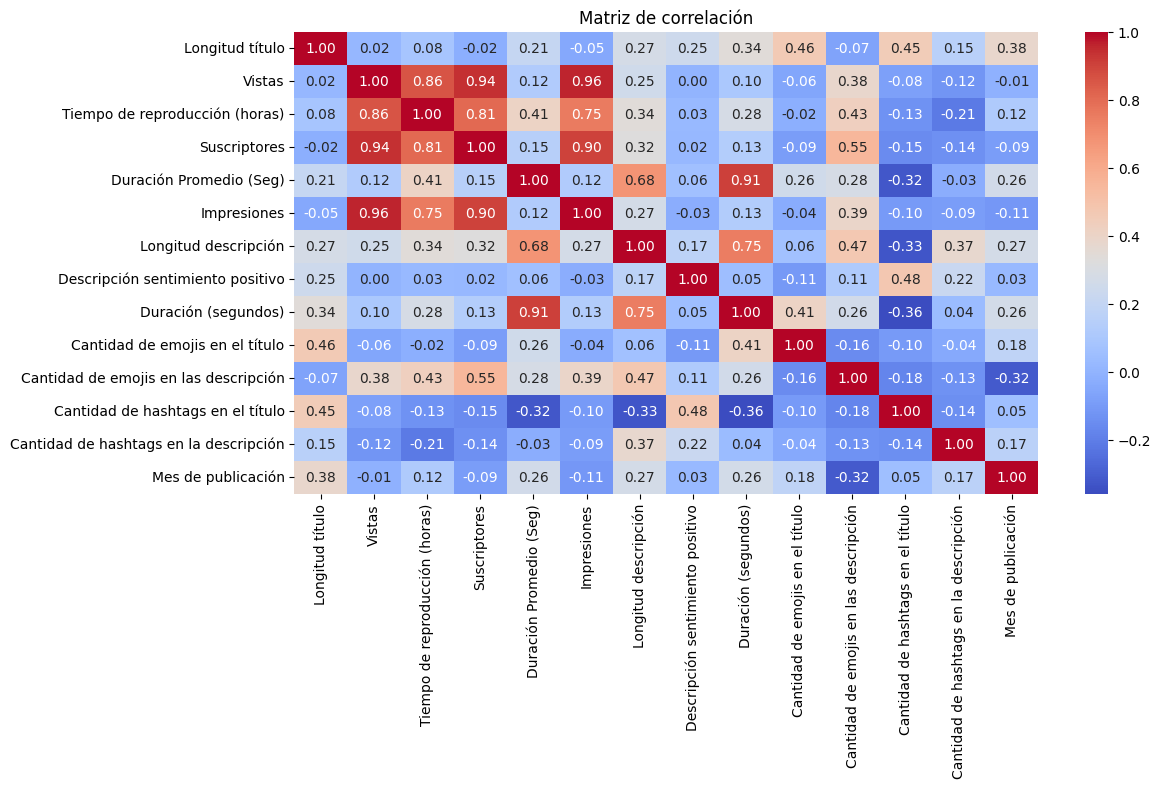

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv('videos.csv')
correlation_matrix = df[valores_numéricos].corr()

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Las siguientes pruebas se realizaran con ambos modelos de datos, crudos y normalizados con RobustScaler, para ver que resultados obtenemos.

Dado que tenemos valores categóricos, vamos a probar tanto label encoding como one hot encoding, para ver que resultados obtenemos.

Del mismo modo probar con K-Means y K-Prototypes, para ver que resultados obtenemos.

Las métricas serán:

El Silhouette Score mide qué tan bien se ajustan los puntos dentro de su propio clúster y qué tan separados están de los demás clústeres. </br>
El Calinski-Harabasz Index (también conocido como el índice de varianza entre grupos) evalúa la dispersión de los clústeres tanto dentro como fuera de ellos. Cuanto más grande sea el índice, mejor será la separación de los clústeres. </br>
El Davies-Bouldin Index mide la calidad de la separación entre los clústeres. Se calcula como la media de la razón entre la distancia intra-clúster y la distancia inter-clúster.</br>
</div>

In [7]:
valores_numéricos = [
    'Longitud título', 'Vistas', 'Tiempo de reproducción (horas)', 'Suscriptores', 'Duración Promedio (Seg)',
    'Impresiones', 'Longitud descripción', 'Descripción sentimiento positivo', 'Duración (segundos)', 'Cantidad de emojis en el título',
    'Cantidad de emojis en las descripción', 'Cantidad de hashtags en el título', 'Cantidad de hashtags en la descripción','Mes de publicación'
]

In [6]:
valores_categóricos = [
      'Categoría', 'Tipo de duración', 'Grupo de color familiar',
    'Temperatura', 'Celebración cercana (agrupado)', 'Países de celebración cercana',
    'Relación con festividad', 'Grupo Horario', 'Cuartiles (Mes)'
]

In [51]:
valores_numéricos = [
    'Longitud título', 'Vistas', 'Suscriptores',
    'Longitud descripción', 'Descripción sentimiento positivo', 'Duración (segundos)', 'Cantidad de emojis en el título',
    'Cantidad de emojis en las descripción', 'Cantidad de hashtags en el título', 'Cantidad de hashtags en la descripción','Mes de publicación'
]

In [ ]:
# valores_numéricos = [
#     'Longitud título', 'Vistas',
#     'Longitud descripción', 'Descripción sentimiento positivo', 'Duración (segundos)', 'Cantidad de emojis en el título',
#     'Cantidad de emojis en las descripción', 'Cantidad de hashtags en el título', 'Cantidad de hashtags en la descripción','Mes de publicación'
# ]

In [28]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

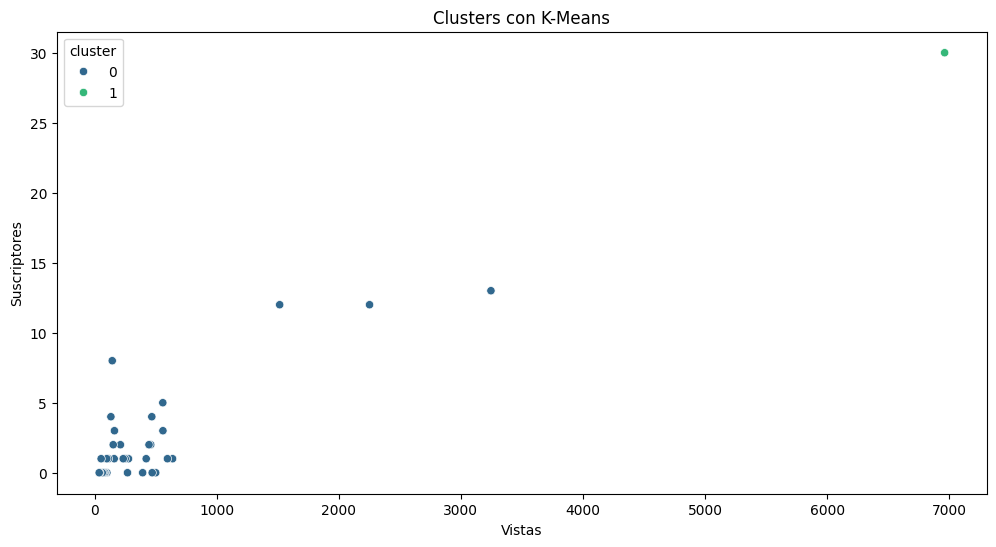

Silueta: 0.931
Calinski-Harabasz: 378.972
Davies-Bouldin: 0.030


In [9]:
# Modelo con datos crudos usando k-means, 2 clusters
df = pd.read_csv('videos.csv')

kmeans = KMeans(n_clusters=2, random_state=0)
df['cluster'] = kmeans.fit_predict(df[valores_numéricos])

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Means')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
# Silueta
silhouette = silhouette_score(df[valores_numéricos], df['cluster'])
print(f"Silueta: {silhouette:.3f}")

# Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(df[valores_numéricos], df['cluster'])
print(f"Calinski-Harabasz: {calinski_harabasz:.3f}")

# Davies-Bouldin
davies_bouldin = davies_bouldin_score(df[valores_numéricos], df['cluster'])
print(f"Davies-Bouldin: {davies_bouldin:.3f}")

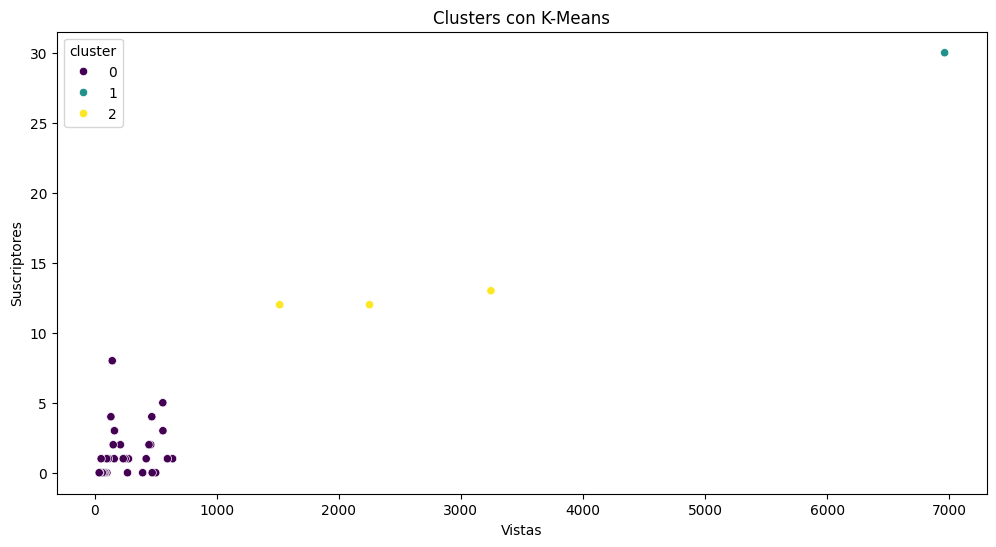

Silueta: 0.828
Calinski-Harabasz: 892.660
Davies-Bouldin: 0.321


In [10]:
# Modelo con datos crudos usando k-means, 3 clusters
df = pd.read_csv('videos.csv')

kmeans = KMeans(n_clusters=3, random_state=0)
df['cluster'] = kmeans.fit_predict(df[valores_numéricos])

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Means')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
# Silueta
silhouette = silhouette_score(df[valores_numéricos], df['cluster'])
print(f"Silueta: {silhouette:.3f}")

# Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(df[valores_numéricos], df['cluster'])
print(f"Calinski-Harabasz: {calinski_harabasz:.3f}")

# Davies-Bouldin
davies_bouldin = davies_bouldin_score(df[valores_numéricos], df['cluster'])
print(f"Davies-Bouldin: {davies_bouldin:.3f}")


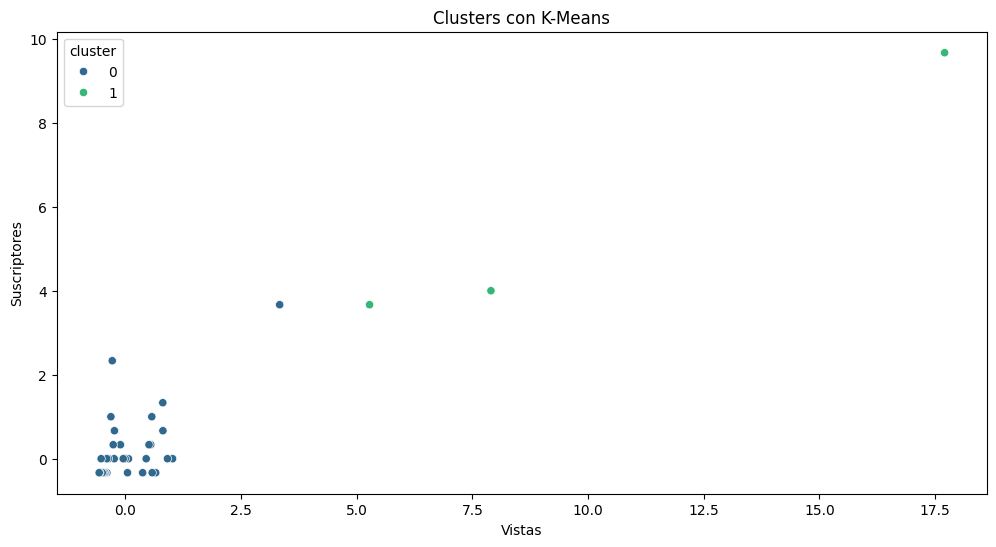

Silueta: 0.637
Calinski-Harabasz: 33.196
Davies-Bouldin: 0.719


In [ ]:
# Modelo con datos con RobustScaler usando k-means, 2 clusters
df = pd.read_csv('videos.csv')

# Probando usando RobustScaler
for col in valores_numéricos:
        robustScaler = RobustScaler()
        df[col] = robustScaler.fit_transform(df[[col]])
        
kmeans = KMeans(n_clusters=2, random_state=0)
df['cluster'] = kmeans.fit_predict(df[valores_numéricos])

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Means')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
# Silueta
silhouette = silhouette_score(df[valores_numéricos], df['cluster'])
print(f"Silueta: {silhouette:.3f}")

# Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(df[valores_numéricos], df['cluster'])
print(f"Calinski-Harabasz: {calinski_harabasz:.3f}")

# Davies-Bouldin
davies_bouldin = davies_bouldin_score(df[valores_numéricos], df['cluster'])
print(f"Davies-Bouldin: {davies_bouldin:.3f}")


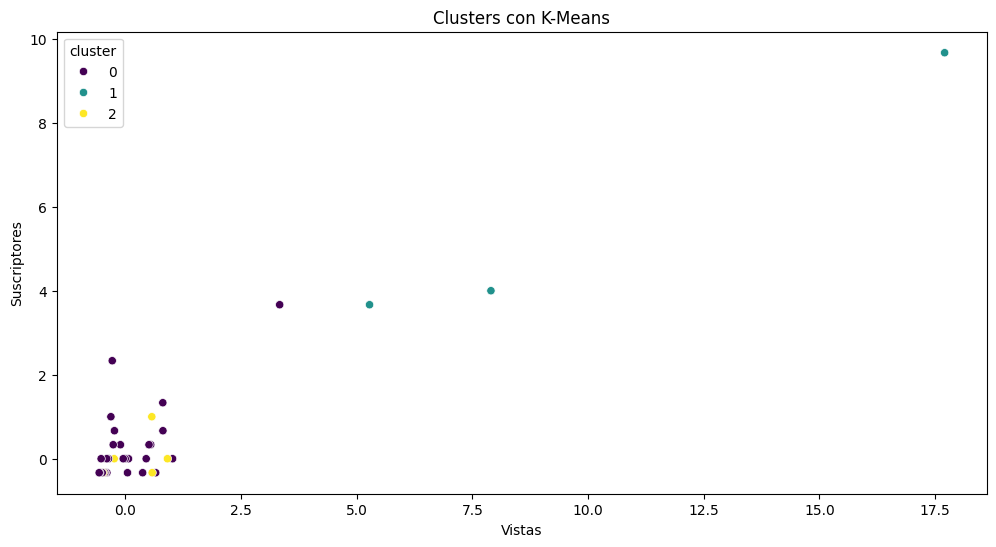

Silueta: 0.323
Calinski-Harabasz: 23.868
Davies-Bouldin: 0.935


In [ ]:
# Modelo con datos con RobustScaler usando k-means, 3 clusters
df = pd.read_csv('videos.csv')

# Probando usando RobustScaler
for col in valores_numéricos:
        robustScaler = RobustScaler()
        df[col] = robustScaler.fit_transform(df[[col]])
        
kmeans = KMeans(n_clusters=3, random_state=0)
df['cluster'] = kmeans.fit_predict(df[valores_numéricos])

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Means')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
# Silueta
silhouette = silhouette_score(df[valores_numéricos], df['cluster'])
print(f"Silueta: {silhouette:.3f}")

# Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(df[valores_numéricos], df['cluster'])
print(f"Calinski-Harabasz: {calinski_harabasz:.3f}")

# Davies-Bouldin
davies_bouldin = davies_bouldin_score(df[valores_numéricos], df['cluster'])
print(f"Davies-Bouldin: {davies_bouldin:.3f}")

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1, ncost: 21546750.26891258
Run: 1, iteration: 2/100, moves: 0, ncost: 21546750.26891258
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1, ncost: 21546750.26891258
Run: 2, iteration: 2/100, moves: 0, ncost: 21546750.26891258
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 13, ncost: 49689124.524087995
Run: 3, iteration: 2/100, moves: 12, ncost: 26209020.043188207
Run: 3, iteration: 3/100, moves: 2, ncost: 21546750.26891258
Run: 3, iteration: 4/100, moves: 0, ncost: 21546750.26891258
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 8, ncost: 48326598.908390604
Run: 4, iteration: 2/100, moves: 10, ncost: 262090

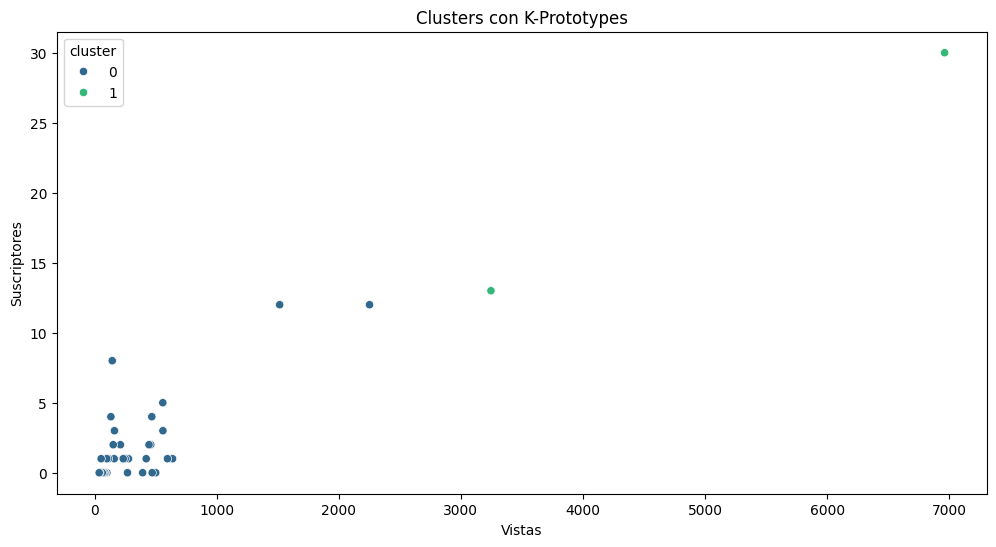

Silueta: 0.792
Calinski-Harabasz: 70.372
Davies-Bouldin: 0.502


In [ ]:
# Modelo con datos crudos usando k-prototype, 2 clusters
df = pd.read_csv('videos.csv')

kproto = KPrototypes(n_clusters=2, init='Cao', n_init=10, verbose=2)
df['cluster'] = kproto.fit_predict(df[valores_numéricos], categorical=[0])

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Prototypes')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin

# Silueta
silhouette = silhouette_score(df[valores_numéricos], df['cluster'])
print(f"Silueta: {silhouette:.3f}")

# Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(df[valores_numéricos], df['cluster'])
print(f"Calinski-Harabasz: {calinski_harabasz:.3f}")

# Davies-Bouldin
davies_bouldin = davies_bouldin_score(df[valores_numéricos], df['cluster'])
print(f"Davies-Bouldin: {davies_bouldin:.3f}")

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 11, ncost: 18856773.930781186
Run: 1, iteration: 2/100, moves: 4, ncost: 17123933.526443575
Run: 1, iteration: 3/100, moves: 0, ncost: 17123933.526443575
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 5, ncost: 17436888.284581657
Run: 2, iteration: 2/100, moves: 5, ncost: 15150271.67297476
Run: 2, iteration: 3/100, moves: 0, ncost: 15150271.67297476
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 1, ncost: 17140103.7706976
Run: 3, iteration: 2/100, moves: 0, ncost: 17140103.7706976
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 3, ncost: 16916536.611137547
Run: 4, iteration: 2/100, moves: 0, ncost: 16916536

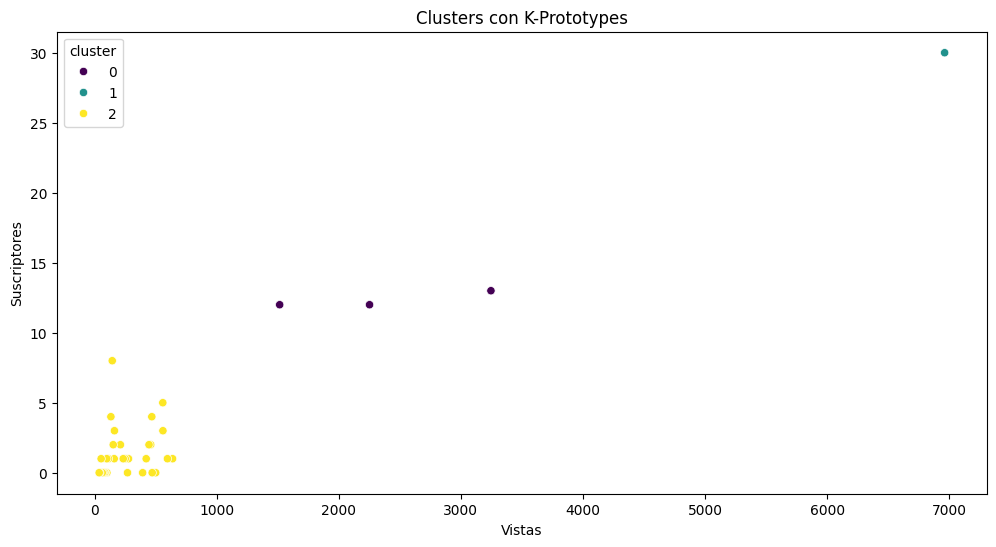

Silueta: 0.667
Calinski-Harabasz: 94.820
Davies-Bouldin: 0.377


In [ ]:
# Modelo con datos crudos usando k-prototype, 3 clusters

df = pd.read_csv('videos.csv')

kproto = KPrototypes(n_clusters=3, init='Cao', n_init=10, verbose=2)
df['cluster'] = kproto.fit_predict(df[valores_numéricos], categorical=[0])

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Prototypes')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin

# Silueta
silhouette = silhouette_score(df[valores_numéricos], df['cluster'])
print(f"Silueta: {silhouette:.3f}")

# Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(df[valores_numéricos], df['cluster'])
print(f"Calinski-Harabasz: {calinski_harabasz:.3f}")

# Davies-Bouldin
davies_bouldin = davies_bouldin_score(df[valores_numéricos], df['cluster'])
print(f"Davies-Bouldin: {davies_bouldin:.3f}")

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 17, ncost: 560.0900857310216
Run: 1, iteration: 2/100, moves: 6, ncost: 403.4843609914531
Run: 1, iteration: 3/100, moves: 1, ncost: 380.8010634911125
Run: 1, iteration: 4/100, moves: 1, ncost: 369.325275936328
Run: 1, iteration: 5/100, moves: 0, ncost: 369.325275936328
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 12, ncost: 504.84779234370825
Run: 2, iteration: 2/100, moves: 5, ncost: 380.8010634911125
Run: 2, iteration: 3/100, moves: 1, ncost: 369.325275936328
Run: 2, iteration: 4/100, moves: 0, ncost: 369.325275936328
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 1, ncost: 369.32527593632796
Run: 3, iteration: 2/100, moves: 0, ncost: 369.32527593632796
Init: initia

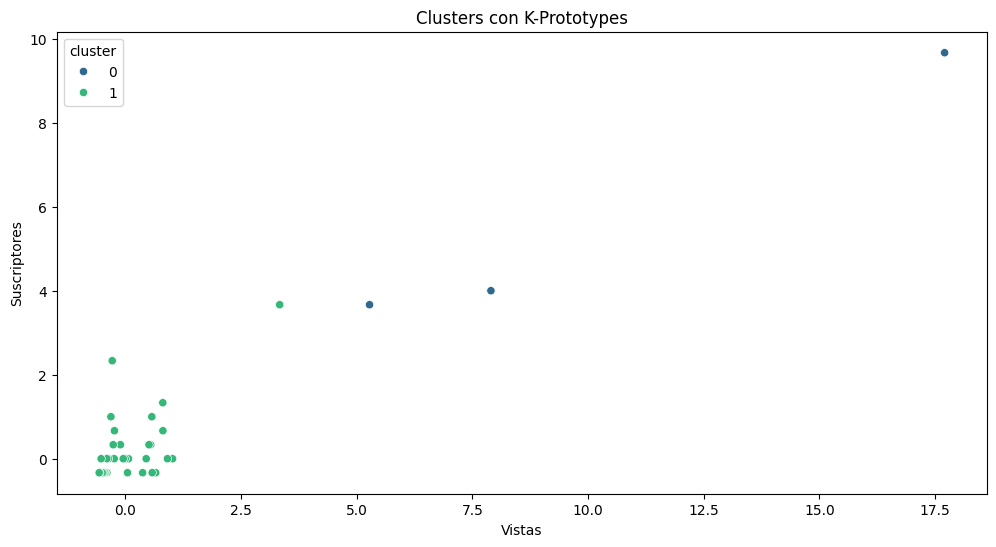

Silueta: 0.637
Calinski-Harabasz: 33.196
Davies-Bouldin: 0.719


In [ ]:
# Modelo con datos con RobustScaler usando k-prototype, 2 clusters
df = pd.read_csv('videos.csv')

# Probando usando RobustScaler
for col in valores_numéricos:
        robustScaler = RobustScaler()
        df[col] = robustScaler.fit_transform(df[[col]])

kproto = KPrototypes(n_clusters=2, init='Cao', n_init=10, verbose=2)
df['cluster'] = kproto.fit_predict(df[valores_numéricos], categorical=[0])

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Prototypes')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin

# Silueta
silhouette = silhouette_score(df[valores_numéricos], df['cluster'])
print(f"Silueta: {silhouette:.3f}")

# Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(df[valores_numéricos], df['cluster'])
print(f"Calinski-Harabasz: {calinski_harabasz:.3f}")

# Davies-Bouldin
davies_bouldin = davies_bouldin_score(df[valores_numéricos], df['cluster'])
print(f"Davies-Bouldin: {davies_bouldin:.3f}")

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 4, ncost: 294.70683796609575
Run: 1, iteration: 2/100, moves: 0, ncost: 294.70683796609575
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1, ncost: 343.5582155415611
Run: 2, iteration: 2/100, moves: 0, ncost: 343.5582155415611
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 2, ncost: 343.2208741941181
Run: 3, iteration: 2/100, moves: 0, ncost: 343.2208741941181
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 10, ncost: 401.3284318500046
Run: 4, iteration: 2/100, moves: 4, ncost: 309.71667324801126
Run: 4, iteration: 3/100, moves: 1, ncost: 298.11738611166544
Run: 4, iteration: 4/100, moves: 0, ncost: 298.117

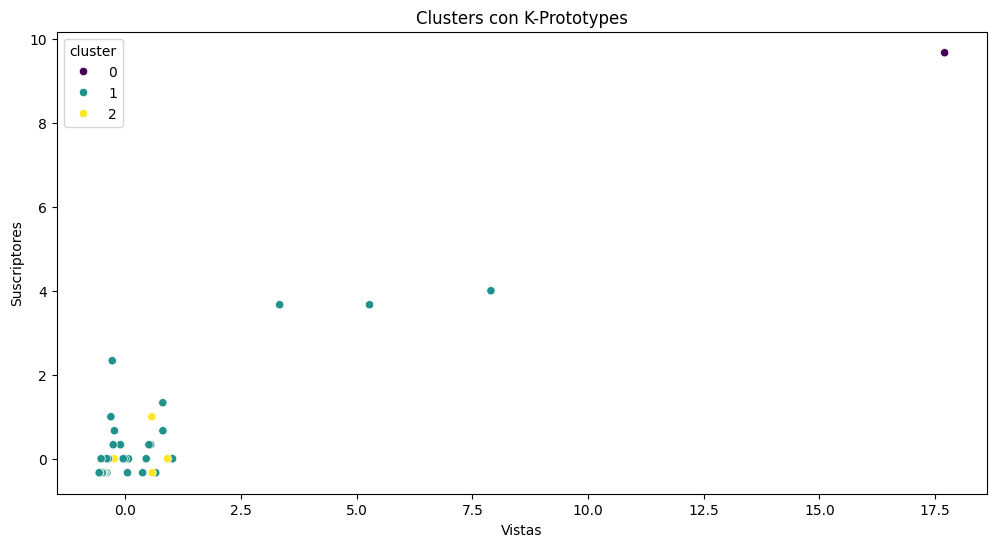

Silueta: 0.273
Calinski-Harabasz: 24.286
Davies-Bouldin: 0.808


In [ ]:
# Modelo con datos con RobustScaler usando k-prototype, 3 clusters

df = pd.read_csv('videos.csv')

# Probando usando RobustScaler
for col in valores_numéricos:
        robustScaler = RobustScaler()
        df[col] = robustScaler.fit_transform(df[[col]])

kproto = KPrototypes(n_clusters=3, init='Cao', n_init=10, verbose=2)
df['cluster'] = kproto.fit_predict(df[valores_numéricos], categorical=[0])

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Prototypes')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin

# Silueta
silhouette = silhouette_score(df[valores_numéricos], df['cluster'])
print(f"Silueta: {silhouette:.3f}")

# Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(df[valores_numéricos], df['cluster'])
print(f"Calinski-Harabasz: {calinski_harabasz:.3f}")

# Davies-Bouldin
davies_bouldin = davies_bouldin_score(df[valores_numéricos], df['cluster'])
print(f"Davies-Bouldin: {davies_bouldin:.3f}")

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Luego de realizar las pruebas, los mejores resultados son los mismos esperados con los datos crudos, con K-Prototypes y 2 clusters.  Esto incluyendo los datos no controlables. Para datos controlables, los resultados siguen siendo los mismos esperados (que son peores que usando los datos no controlables).
</div> 

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Hasta ahora, la pruebas se han realizado sin tomar en cuenta los datos categóricos, por lo que vamos a realizar pruebas con los datos categóricos, para ver que resultados obtenemos. Tomando los datos crudos y normalizados con RobustScaler.

Vamos a probar todas las combinaciones posibles, para ver que resultados obtenemos. Entiéndase datos crudos con datos categóricos con One Hot Encoding, Label Encoding, K-Means y K-Prototypes. Lo mismo con los datos normalizados con RobustScaler.
</div>

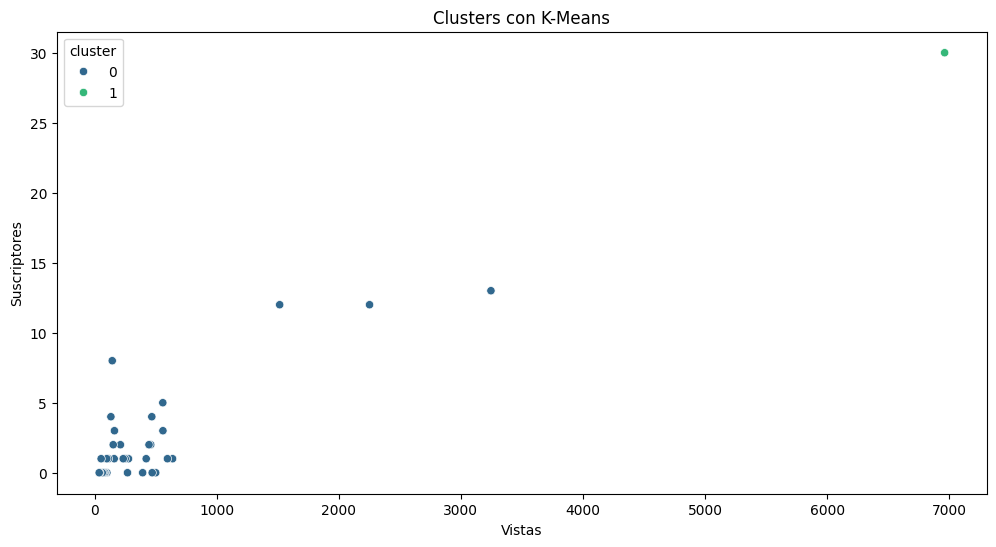

Métricas del modelo:
- Silueta: 0.931
- Calinski-Harabasz: 378.972
- Davies-Bouldin: 0.030


In [41]:
# Modelo con datos no normalizados usando k-means, datos categóricos normalizados con onehot, 2 clusters
df = pd.read_csv('videos.csv')

onehot_encoder = OneHotEncoder()
valores_categóricos_normalizados = onehot_encoder.fit_transform(df[valores_categóricos])

df_transformado = np.hstack((df[valores_numéricos], valores_categóricos_normalizados.toarray()))

kmeans = KMeans(n_clusters=2, random_state=0)
df['cluster'] = kmeans.fit_predict(df_transformado)

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Means')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
silhouette = silhouette_score(df_transformado, df['cluster'])
calinski_harabasz = calinski_harabasz_score(df_transformado, df['cluster'])
davies_bouldin = davies_bouldin_score(df_transformado, df['cluster'])

print(f"Métricas del modelo:")
print(f"- Silueta: {silhouette:.3f}")
print(f"- Calinski-Harabasz: {calinski_harabasz:.3f}")
print(f"- Davies-Bouldin: {davies_bouldin:.3f}")

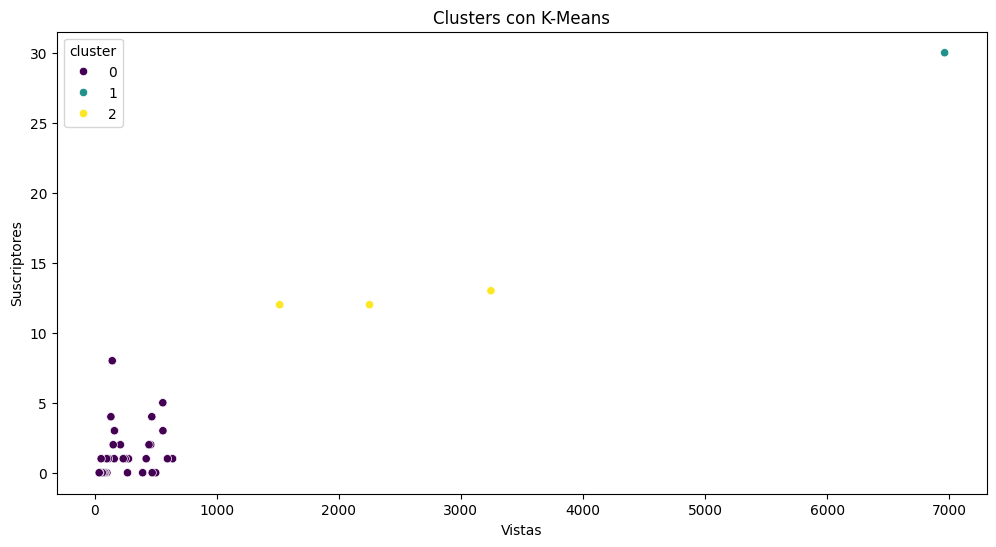

Métricas del modelo:
- Silueta: 0.828
- Calinski-Harabasz: 892.660
- Davies-Bouldin: 0.321


In [8]:
# Modelo con datos no normalizados usando k-means, datos categóricos normalizados con onehot, 3 clusters
df = pd.read_csv('videos.csv')

onehot_encoder = OneHotEncoder()
valores_categóricos_normalizados = onehot_encoder.fit_transform(df[valores_categóricos])

df_transformado = np.hstack((df[valores_numéricos], valores_categóricos_normalizados.toarray()))

kmeans = KMeans(n_clusters=3, random_state=0)
df['cluster'] = kmeans.fit_predict(df_transformado)

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Means')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
silhouette = silhouette_score(df_transformado, df['cluster'])
calinski_harabasz = calinski_harabasz_score(df_transformado, df['cluster'])
davies_bouldin = davies_bouldin_score(df_transformado, df['cluster'])

print(f"Métricas del modelo:")
print(f"- Silueta: {silhouette:.3f}")
print(f"- Calinski-Harabasz: {calinski_harabasz:.3f}")
print(f"- Davies-Bouldin: {davies_bouldin:.3f}")

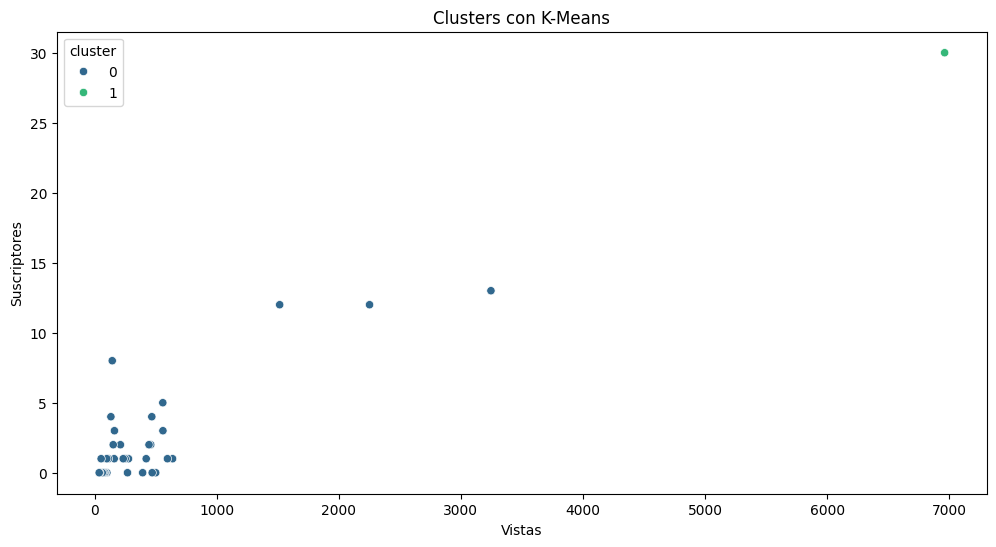

Métricas del modelo:
- Silueta: 0.931
- Calinski-Harabasz: 378.972
- Davies-Bouldin: 0.030


In [42]:
# Modelo con datos no normalizados usando k-means, datos categóricos normalizados con Label, 2 clusters
df = pd.read_csv('videos.csv')

label_encoders = {}
for col in valores_categóricos:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

valores_combinados = valores_numéricos + valores_categóricos

kmeans = KMeans(n_clusters=2, random_state=0)
df['cluster'] = kmeans.fit_predict(df_transformado)

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Means')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
silhouette = silhouette_score(df[valores_combinados], df['cluster'])
calinski_harabasz = calinski_harabasz_score(df[valores_combinados], df['cluster'])
davies_bouldin = davies_bouldin_score(df[valores_combinados], df['cluster'])

print(f"Métricas del modelo:")
print(f"- Silueta: {silhouette:.3f}")
print(f"- Calinski-Harabasz: {calinski_harabasz:.3f}")
print(f"- Davies-Bouldin: {davies_bouldin:.3f}")


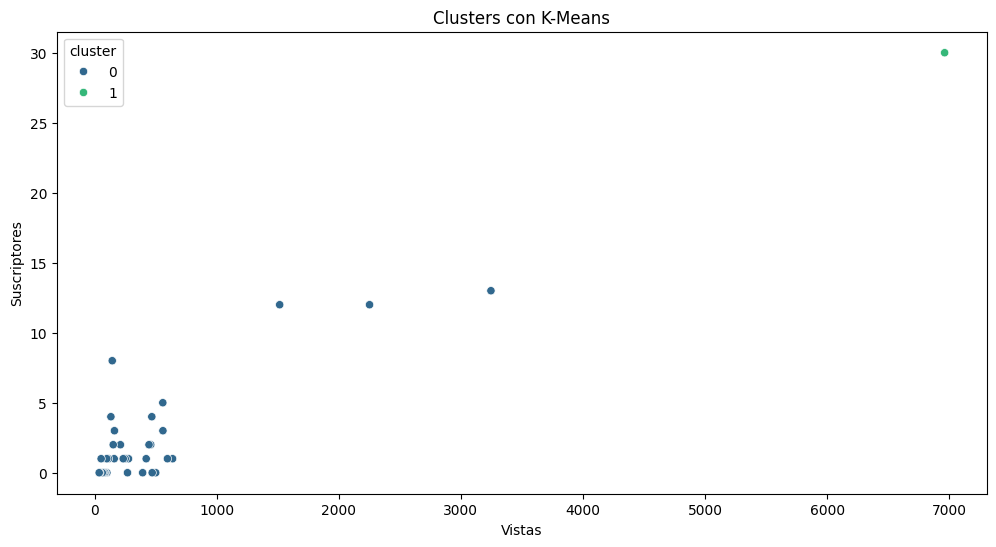

Métricas del modelo:
- Silueta: 0.838
- Calinski-Harabasz: 71.058
- Davies-Bouldin: 0.090


In [43]:
# Modelo con datos normalizado con RobustScaler usando k-means, datos categóricos normalizados con onehot, 2 clusters
df = pd.read_csv('videos.csv')

onehot_encoder = OneHotEncoder()
valores_categóricos_normalizados = onehot_encoder.fit_transform(df[valores_categóricos])

scaler = RobustScaler()
valores_numéricos_normalizados = scaler.fit_transform(df[valores_numéricos])

df_transformado = np.hstack((valores_numéricos_normalizados, valores_categóricos_normalizados.toarray()))

kmeans = KMeans(n_clusters=2, random_state=0)
df['cluster'] = kmeans.fit_predict(df_transformado)

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Means')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
silhouette = silhouette_score(df_transformado, df['cluster'])
calinski_harabasz = calinski_harabasz_score(df_transformado, df['cluster'])
davies_bouldin = davies_bouldin_score(df_transformado, df['cluster'])

print(f"Métricas del modelo:")
print(f"- Silueta: {silhouette:.3f}")
print(f"- Calinski-Harabasz: {calinski_harabasz:.3f}")
print(f"- Davies-Bouldin: {davies_bouldin:.3f}")


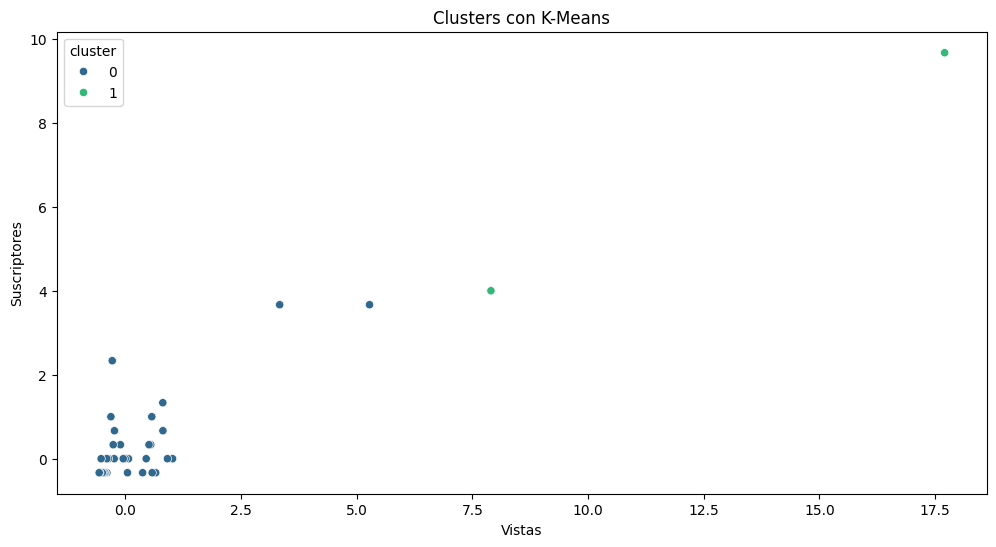

Métricas del modelo:
- Silueta: 0.737
- Calinski-Harabasz: 42.481
- Davies-Bouldin: 0.679


In [47]:
# Modelo con datos normalizados con RobustScaler usando k-means, datos categóricos normalizados con Label, 2 clusters
df = pd.read_csv('videos.csv')

label_encoders = {}
for col in valores_categóricos:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

scaler = RobustScaler()
df[valores_numéricos] = scaler.fit_transform(df[valores_numéricos])

valores_combinados = valores_numéricos + valores_categóricos

kmeans = KMeans(n_clusters=2, random_state=0)
df['cluster'] = kmeans.fit_predict(df[valores_combinados])

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Means')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
silhouette = silhouette_score(df[valores_combinados], df['cluster'])
calinski_harabasz = calinski_harabasz_score(df[valores_combinados], df['cluster'])
davies_bouldin = davies_bouldin_score(df[valores_combinados], df['cluster'])

print(f"Métricas del modelo:")
print(f"- Silueta: {silhouette:.3f}")
print(f"- Calinski-Harabasz: {calinski_harabasz:.3f}")
print(f"- Davies-Bouldin: {davies_bouldin:.3f}")


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1, ncost: 5802387709.207214
Run: 1, iteration: 2/100, moves: 0, ncost: 5802387709.207214
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3, ncost: 16124069661.500708
Run: 2, iteration: 2/100, moves: 1, ncost: 5802387709.207214
Run: 2, iteration: 3/100, moves: 0, ncost: 5802387709.207214
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 3, ncost: 16124069661.500708
Run: 3, iteration: 2/100, moves: 1, ncost: 5802387709.207214
Run: 3, iteration: 3/100, moves: 0, ncost: 5802387709.207214
Init: initializing cent

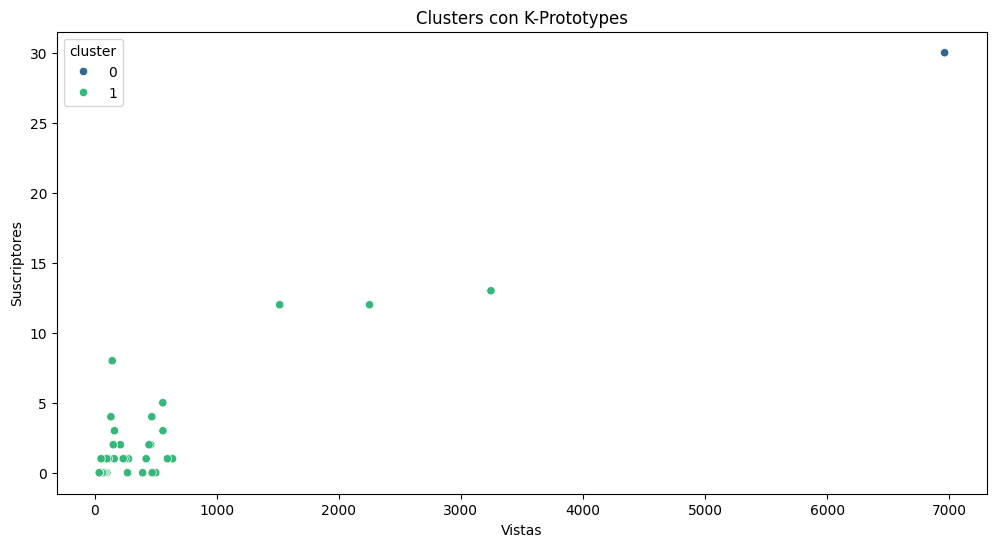

Métricas del modelo:
- Silueta: 0.931
- Calinski-Harabasz: 378.972
- Davies-Bouldin: 0.030


In [49]:
# Modelo con datos no normalizados usando k-prototype, 2 clusters
df = pd.read_csv('videos.csv')

df = df[valores_numéricos + valores_categóricos]

# Debemos entregar los datos por separado
kproto = KPrototypes(n_clusters=2, init='Cao', n_init=10, verbose=2)
categorical_indices = [df.columns.get_loc(col) for col in valores_categóricos]
clusters = kproto.fit_predict(df, categorical=categorical_indices)

df['cluster'] = clusters

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Prototypes')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
silhouette = silhouette_score(df[valores_numéricos], df['cluster'])
calinski_harabasz = calinski_harabasz_score(df[valores_numéricos], df['cluster'])
davies_bouldin = davies_bouldin_score(df[valores_numéricos], df['cluster'])

print(f"Métricas del modelo:")
print(f"- Silueta: {silhouette:.3f}")
print(f"- Calinski-Harabasz: {calinski_harabasz:.3f}")
print(f"- Davies-Bouldin: {davies_bouldin:.3f}")


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 2114154680.7395046
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 12, ncost: 30804112810.491627
Run: 2, iteration: 2/100, moves: 6, ncost: 13103282817.650372
Run: 2, iteration: 3/100, moves: 4, ncost: 1424686276.5129936
Run: 2, iteration: 4/100, moves: 1, ncost: 1275694128.8856819
Run: 2, iteration: 5/100, moves: 0, ncost: 1275694128.8856819
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, 

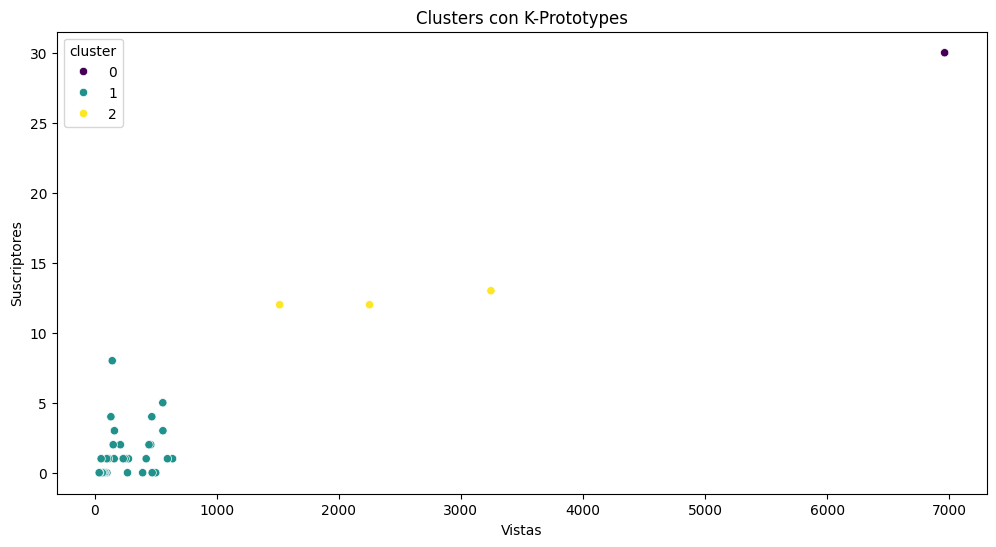

Métricas del modelo:
- Silueta: 0.828
- Calinski-Harabasz: 892.660
- Davies-Bouldin: 0.321


In [12]:
# Modelo con datos no normalizados usando k-prototype, 3 clusters
df = pd.read_csv('videos.csv')

df = df[valores_numéricos + valores_categóricos]

# Debemos entregar los datos por separado
kproto = KPrototypes(n_clusters=3, init='Cao', n_init=10, verbose=2)
categorical_indices = [df.columns.get_loc(col) for col in valores_categóricos]
clusters = kproto.fit_predict(df, categorical=categorical_indices)

df['cluster'] = clusters

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Prototypes')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
silhouette = silhouette_score(df[valores_numéricos], df['cluster'])
calinski_harabasz = calinski_harabasz_score(df[valores_numéricos], df['cluster'])
davies_bouldin = davies_bouldin_score(df[valores_numéricos], df['cluster'])

print(f"Métricas del modelo:")
print(f"- Silueta: {silhouette:.3f}")
print(f"- Calinski-Harabasz: {calinski_harabasz:.3f}")
print(f"- Davies-Bouldin: {davies_bouldin:.3f}")


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 13, ncost: 606.4415527280844
Run: 1, iteration: 2/100, moves: 6, ncost: 468.3181250338458
Run: 1, iteration: 3/100, moves: 1, ncost: 456.72036607943323
Run: 1, iteration: 4/100, moves: 0, ncost: 456.72036607943323
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 6, ncost: 595.2111471984477
Run: 2, iteration: 2/100, moves: 5, ncost: 468.3181250338458
Run: 2, iteration: 3/100, moves: 1, ncost: 456.72036607943323
Run: 2, iteration: 4/100, moves: 0, ncost: 456.72036607943323
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 456.72036607943323
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 2, ncost: 468.31

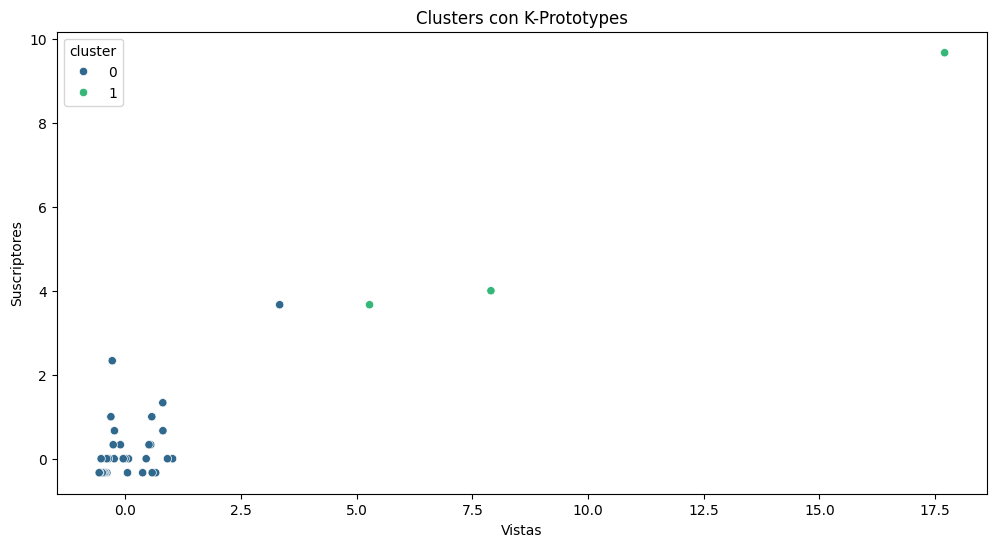

Métricas del modelo:
- Silueta: 0.637
- Calinski-Harabasz: 33.196
- Davies-Bouldin: 0.719


In [52]:
# Modelo con datos normalizados con RobustScaler usando k-prototype 2 clusters
df = pd.read_csv('videos.csv')

df = df[valores_numéricos + valores_categóricos]

# Probando usando RobustScaler
for col in valores_numéricos:
        robustScaler = RobustScaler()
        df[col] = robustScaler.fit_transform(df[[col]])

# Debemos entregar los datos por separado
kproto = KPrototypes(n_clusters=2, init='Cao', n_init=10, verbose=2)
categorical_indices = [df.columns.get_loc(col) for col in valores_categóricos]
clusters = kproto.fit_predict(df, categorical=categorical_indices)

df['cluster'] = clusters

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Prototypes')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
silhouette = silhouette_score(df[valores_numéricos], df['cluster'])
calinski_harabasz = calinski_harabasz_score(df[valores_numéricos], df['cluster'])
davies_bouldin = davies_bouldin_score(df[valores_numéricos], df['cluster'])

print(f"Métricas del modelo:")
print(f"- Silueta: {silhouette:.3f}")
print(f"- Calinski-Harabasz: {calinski_harabasz:.3f}")
print(f"- Davies-Bouldin: {davies_bouldin:.3f}")


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 7, ncost: 1954.6852425678335
Run: 1, iteration: 2/100, moves: 2, ncost: 1469.4579614232944
Run: 1, iteration: 3/100, moves: 0, ncost: 1469.4579614232944
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 1469.4579614232944
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 6, ncost: 1953.7406673002129
Run: 3, iteration: 2/100, moves: 2, ncost: 1469.4579614232944
Run: 3, iteration: 3/100, moves: 0, ncost: 1469.4579614232944
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 1, ncost: 1469.4579614232944
Run: 4, iteration: 2/100, moves: 0, ncost: 1469.4579614232944
Init: initializing centroids
Init: initializin

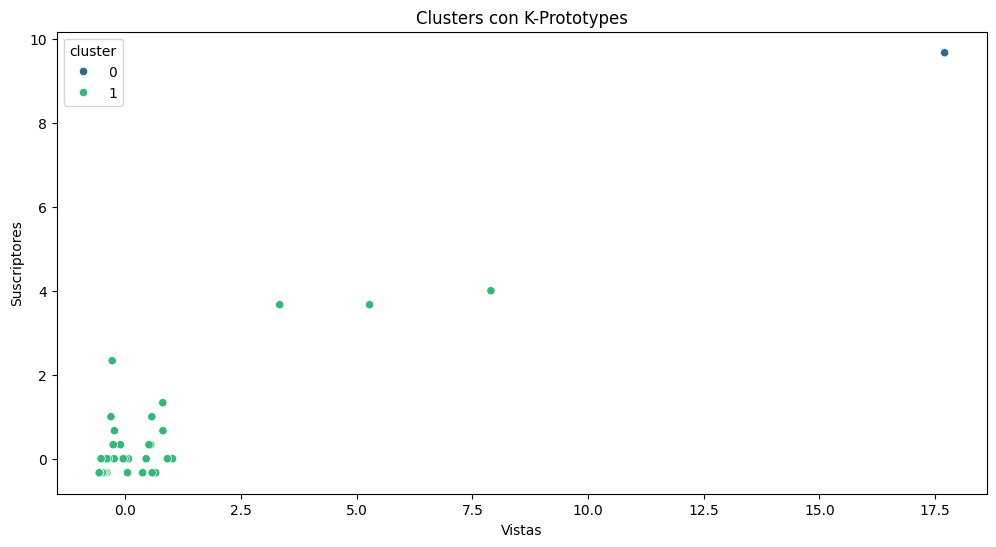

Métricas del modelo:
- Silueta: 0.858
- Calinski-Harabasz: 82.023
- Davies-Bouldin: 0.076


In [57]:
# Modelo con datos normalizados con RobustScaler usando k-prototype 2 clusters
df = pd.read_csv('videos.csv')

df = df[valores_numéricos + valores_categóricos]

# Probando usando RobustScaler
for col in valores_numéricos:
        robustScaler = RobustScaler()
        df[col] = robustScaler.fit_transform(df[[col]])

# Debemos entregar los datos por separado
kproto = KPrototypes(n_clusters=2, init='Cao', n_init=10, verbose=2)
categorical_indices = [df.columns.get_loc(col) for col in valores_categóricos]
clusters = kproto.fit_predict(df, categorical=categorical_indices)

df['cluster'] = clusters

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Vistas', y='Suscriptores', hue='cluster', palette='viridis')
plt.title('Clusters con K-Prototypes')
plt.show()

# Métricas a medir, Siluete, Calinski-Harabasz y Davies-Bouldin
silhouette = silhouette_score(df[valores_numéricos], df['cluster'])
calinski_harabasz = calinski_harabasz_score(df[valores_numéricos], df['cluster'])
davies_bouldin = davies_bouldin_score(df[valores_numéricos], df['cluster'])

print(f"Métricas del modelo:")
print(f"- Silueta: {silhouette:.3f}")
print(f"- Calinski-Harabasz: {calinski_harabasz:.3f}")
print(f"- Davies-Bouldin: {davies_bouldin:.3f}")


<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Luego de todas las pruebas realizadas,  de todos modos el mejor modelo es con los datos crudos, con K-Means, sean los valores catergóricos con One Hot Encoding o Label Encoding (Aunque con OneHot obtenemos un mejor Calinski, pero muy poco). 

Esto incluyendo los datos no controlables. Para datos controlables, los resultados siguen siendo los mismo.

El modelo de K-Prototypes tampoco da un resultado muy malo, es más, es muy similar al de K-Means, pero con un Silhouette Score un poco más bajo.

Resultados finales: </br>
K-Means con datos crudos, One Hot Encoding y Datos No Controlables: 0.931. </br>
K-Means con datos crudos, Label Encoding y Datos No Controlables: 0.931. </br>
K-Means con datos crudos, One Hot Encoding y Datos Controlables: 0.829. </br>
K-Means con datos crudos, Label Encoding y Datos Controlables: 0.829. </br>

K-Means con datos normalizados con RobustScaler, One Hot Encoding y Datos No Controlables: 0.838. </br>
K-Means con datos normalizados con RobustScaler, Label Encoding y Datos No Controlables: 0.737. </br>

K-Prototypes con datos crudos, y Datos No Controlables: 0.931. </br>
K-Prototypes con datos normalizados con RobustScaler, y Datos No Controlables: 0.858. </br>
K-Prototypes con datos crudos, y Datos Controlables: 0.792. </br>
K-Prototypes con datos normalizados con RobustScaler, y Datos Controlables: 0.637 </br>

Los datos de K-Means con datos controlables y normalizados con RobustScaler dan un resultado muy bajo, por lo que no se recomienda usar este modelo.
</div>

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Explorando PCA con datos normalizados con RobustScaler, para ver si podemos reducir la dimensionalidad de los datos y mejorar los resultados.


PCA sirve para reducir la dimensionalidad de los datos a costa de perdida de información. Nosotros vamos a trabajar con el 90% de la varianza de los datos, para ver si podemos mejorar los resultados.
</div>

Varianza explicada acumulada por PCA: 0.94
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2, ncost: 1601.812099383924
Run: 1, iteration: 2/100, moves: 0, ncost: 1601.812099383924
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 7, ncost: 2363.4271814355734
Run: 2, iteration: 2/100, moves: 3, ncost: 1601.812099383924
Run: 2, iteration: 3/100, moves: 0, ncost: 1601.812099383924
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 1, ncost: 1601.8120993839243
Run: 3, iteration: 2/100, moves: 0, ncost: 1601.8120993839243
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 4, ncost: 2083.6438111982293
Run: 4, iter

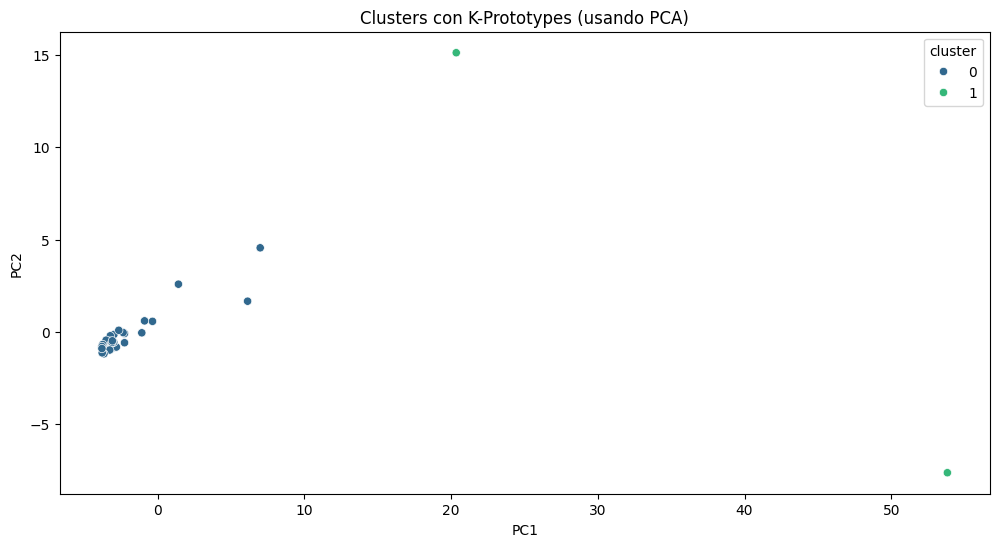

Métricas del modelo:
- Silueta: 0.885
- Calinski-Harabasz: 91.061
- Davies-Bouldin: 0.556


In [ ]:
from sklearn.decomposition import PCA

df = pd.read_csv('videos.csv')
df = df[valores_numéricos + valores_categóricos]

scaler = RobustScaler()
df[valores_numéricos] = scaler.fit_transform(df[valores_numéricos])

# Aplicar PCA a las columnas numéricas
pca = PCA(n_components=0.90)  # Reducimos al 90% de la varianza
num_pca = pca.fit_transform(df[valores_numéricos])
df_pca = pd.DataFrame(num_pca, columns=['PC1', 'PC2'])
print(f"Varianza explicada acumulada por PCA: {sum(pca.explained_variance_ratio_):.2f}")
# Unir las columnas categóricas con las componentes principales de PCA
df_pca_categoricals = pd.concat([df_pca, df[valores_categóricos].reset_index(drop=True)], axis=1)
# Obtener índices de las columnas categóricas en el nuevo DataFrame
categorical_indices = [df_pca_categoricals.columns.get_loc(col) for col in valores_categóricos]

kproto = KPrototypes(n_clusters=2, init='Cao', n_init=10, verbose=2)
clusters = kproto.fit_predict(df_pca_categoricals, categorical=categorical_indices)

df['cluster'] = clusters

# Visualización de los clústeres
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=df['cluster'], palette='viridis')
plt.title('Clusters con K-Prototypes (usando PCA)')
plt.show()

# Métricas de evaluación
silhouette = silhouette_score(num_pca, df['cluster'])
calinski_harabasz = calinski_harabasz_score(num_pca, df['cluster'])
davies_bouldin = davies_bouldin_score(num_pca, df['cluster'])

print(f"Métricas del modelo:")
print(f"- Silueta: {silhouette:.3f}")
print(f"- Calinski-Harabasz: {calinski_harabasz:.3f}")
print(f"- Davies-Bouldin: {davies_bouldin:.3f}")

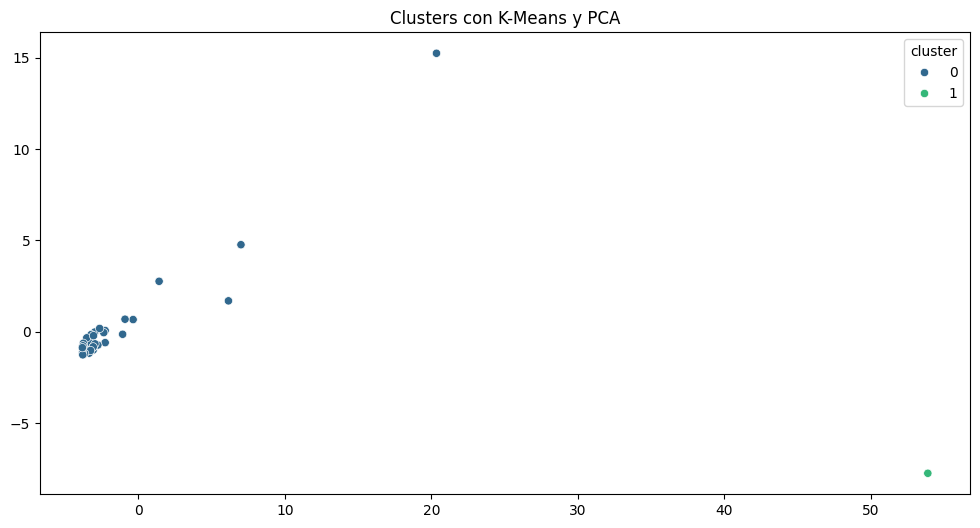

Métricas del modelo:
- Silueta: 0.898
- Calinski-Harabasz: 102.485
- Davies-Bouldin: 0.053


In [61]:
# Modelo con datos normalizado con RobustScaler usando k-means, datos categóricos normalizados con onehot, 2 clusters
df = pd.read_csv('videos.csv')

onehot_encoder = OneHotEncoder()
valores_categóricos_normalizados = onehot_encoder.fit_transform(df[valores_categóricos])

scaler = RobustScaler()
valores_numéricos_normalizados = scaler.fit_transform(df[valores_numéricos])

df_transformado = np.hstack((valores_numéricos_normalizados, valores_categóricos_normalizados.toarray()))

pca = PCA(n_components=0.90)  # Reducimos al 90% de la varianza
df_pca = pca.fit_transform(df_transformado)

kmeans = KMeans(n_clusters=2, random_state=0)
df['cluster'] = kmeans.fit_predict(df_pca)

# Visualización de los clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df['cluster'], palette='viridis')
plt.title('Clusters con K-Means y PCA')
plt.show()

# Métricas a medir
silhouette = silhouette_score(df_pca, df['cluster'])
calinski_harabasz = calinski_harabasz_score(df_pca, df['cluster'])
davies_bouldin = davies_bouldin_score(df_pca, df['cluster'])

print(f"Métricas del modelo:")
print(f"- Silueta: {silhouette:.3f}")
print(f"- Calinski-Harabasz: {calinski_harabasz:.3f}")
print(f"- Davies-Bouldin: {davies_bouldin:.3f}")


<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">
Luego de realizar las pruebas con PCA, podemos ver que los resultados mejoran un poco, por lo que se puede considerar usar PCA para reducir la dimensionalidad de los datos, tomando en cuenta que se pierde información (aunque lo trabajamos al 90% de la varianza).</br>

Resultados finales: </br>
K-Means con datos normalizados con RobustScaler, One Hot Encoding y Datos No Controlables: 0.898. </br>
K-Prototypes con datos normalizados con RobustScaler, y Datos No Controlables: 0.885. </br>
</div>

<div style="background:#FFFFE0;padding:20px;color:#000000;margin-top:10px;">

Algunas referencias utilizadas:

https://stackoverflow.com/questions/62178888/can-someone-explain-to-me-how-minmaxscaler-works
https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
https://scipy.github.io/devdocs/reference/generated/scipy.stats.shapiro.html
https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.RobustScaler.html
</div>